In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # for plotting
import seaborn as sn

In [2]:
# load dataframe from .csv file
application_record = pd.read_csv("./data/details_final.csv")
application_record.drop(['Unnamed: 0', 'aid', 'ID', 'ID.1'], inplace=True, axis=1) # drop unnecessary columns
application_record.drop(['overdue_freq', 'overdue_times'], inplace=True, axis=1) # drop unnecessary columns
application_record.fillna(0, inplace=True) # fill empty cells with zero]

# a quick view
print("Shape of basically processed data:", application_record.shape)
print("Example row:\n", application_record.iloc[0])

Shape of basically processed data: (36457, 19)
Example row:
 CODE_GENDER                           M
FLAG_OWN_CAR                          1
FLAG_OWN_REALTY                       1
CNT_CHILDREN                          0
AMT_INCOME_TOTAL               427500.0
NAME_INCOME_TYPE                Working
NAME_EDUCATION_TYPE    Higher education
NAME_FAMILY_STATUS       Civil marriage
NAME_HOUSING_TYPE      Rented apartment
DAYS_BIRTH                       -12005
DAYS_EMPLOYED                     -4542
FLAG_MOBIL                            1
FLAG_WORK_PHONE                       1
FLAG_PHONE                            0
FLAG_EMAIL                            0
OCCUPATION_TYPE                       0
CNT_FAM_MEMBERS                       2
final_months                        -15
final_status                          X
Name: 0, dtype: object


Yufan's Note: The basically processed data has 19 columns, with 2 labels and 17 features.

In the next part, we will to transform those categorical features (e.g. 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE') and categorical ('final_status') into numerical features with one hot encoding.

In [3]:
## one hot encoding
# ['CODE_GENDER']
application_record['CODE_GENDER'] = application_record['CODE_GENDER'].replace(['F', 'M'], [0, 1])

# ['NAME_INCOME_TYPE']
temp = pd.get_dummies(application_record['NAME_INCOME_TYPE'])
application_record.drop('NAME_INCOME_TYPE', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'INCOME_TYPE(OH).'+str(i), temp.iloc[:,i])
                        
# ['NAME_HOUSING_TYPE']
temp = pd.get_dummies(application_record['NAME_HOUSING_TYPE'])
application_record.drop('NAME_HOUSING_TYPE', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'HOUSING_TYPE(OH).'+str(i), temp.iloc[:,i])
    
# ['NAME_EDUCATION_TYPE']
temp = pd.get_dummies(application_record['NAME_EDUCATION_TYPE'])
application_record.drop('NAME_EDUCATION_TYPE', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'EDUCATION_TYPE(OH).'+str(i), temp.iloc[:,i])
    
# ['NAME_FAMILY_STATUS']
temp = pd.get_dummies(application_record['NAME_FAMILY_STATUS'])
application_record.drop('NAME_FAMILY_STATUS', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'FAMILY_STATUS(OH).'+str(i), temp.iloc[:,i])

# ['OCCUPATION_TYPE']
temp = pd.get_dummies(application_record['OCCUPATION_TYPE'])
application_record.drop('OCCUPATION_TYPE', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'OCCUPATION_TYPE(OH).'+str(i), temp.iloc[:,i])

# ['final_months']
application_record.insert(np.shape(application_record)[1], 'LABEL_MONTHS', application_record['final_months'])
application_record.drop('final_months', inplace=True, axis=1)

# ['final_status']
application_record['final_status'] = application_record['final_status'].replace(['1', '5', 'C'], ['0', '0', '0'])
temp = pd.get_dummies(application_record['final_status'])
application_record.drop('final_status', inplace=True, axis = 1)
for i in range(np.shape(temp)[1]):
    pos = np.shape(application_record)[1]
    application_record.insert(pos, 'LABEL_STATUS(OH).'+str(i), temp.iloc[:,i])

# application_record.drop(['NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS'], inplace=True, axis=1) # drop low correlation columns
    
# a quick view
print("Shape of application record:", application_record.shape)
print("Example row:\n", application_record.iloc[0])

Shape of application record: (36457, 55)
Example row:
 CODE_GENDER                    1.0
FLAG_OWN_CAR                   1.0
FLAG_OWN_REALTY                1.0
CNT_CHILDREN                   0.0
AMT_INCOME_TOTAL          427500.0
DAYS_BIRTH                -12005.0
DAYS_EMPLOYED              -4542.0
FLAG_MOBIL                     1.0
FLAG_WORK_PHONE                1.0
FLAG_PHONE                     0.0
FLAG_EMAIL                     0.0
CNT_FAM_MEMBERS                2.0
INCOME_TYPE(OH).0              0.0
INCOME_TYPE(OH).1              0.0
INCOME_TYPE(OH).2              0.0
INCOME_TYPE(OH).3              0.0
INCOME_TYPE(OH).4              1.0
HOUSING_TYPE(OH).0             0.0
HOUSING_TYPE(OH).1             0.0
HOUSING_TYPE(OH).2             0.0
HOUSING_TYPE(OH).3             0.0
HOUSING_TYPE(OH).4             1.0
HOUSING_TYPE(OH).5             0.0
EDUCATION_TYPE(OH).0           0.0
EDUCATION_TYPE(OH).1           1.0
EDUCATION_TYPE(OH).2           0.0
EDUCATION_TYPE(OH).3           0.0


Yufan's Note: The one-hot encoded data has 56 columns, with 4 labels and 52 features.

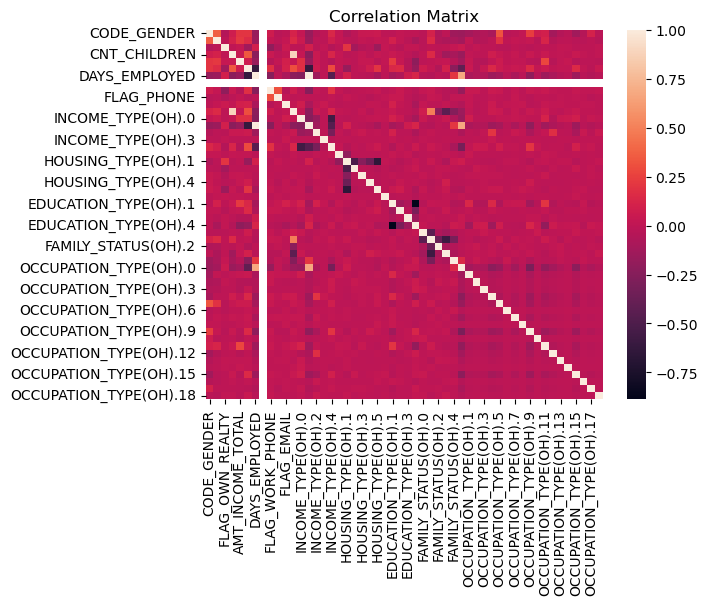

In [4]:
dim = np.shape(application_record)[1]
corr_matrix = application_record.iloc[:,0:(dim-3)].corr()
sn.heatmap(corr_matrix)
plt.title('Correlation Matrix')
plt.savefig('testplot.png')
plt.show()

In [5]:
# get dataset ready for nerual network
train, test = train_test_split(application_record, test_size=0.1) # split dataset (result is numpy.ndarray)

# further split to train/ test data/ label
# as well as convert to numpy array
train_data = train.iloc[:,0:(dim-3)]
train_label_status = train.iloc[:,(dim-2):dim]
test_data = test.iloc[:,0:dim-3]
test_label_status = test.iloc[:,dim-2:dim]

print("Size of train_data: {}".format(np.shape(train_data)))
print("Size of train_label_status: {}".format(np.shape(train_label_status)))
print("Size of test_data: {}".format(np.shape(test_data)))
print("Size of test_label_status: {}".format(np.shape(test_label_status)))

Size of train_data: (32811, 52)
Size of train_label_status: (32811, 2)
Size of test_data: (3646, 52)
Size of test_label_status: (3646, 2)


In [6]:
# build model predicting overdue status
reg = 5e-10
input_length = np.shape(test_data)[1]
output_length = np.shape(test_label_status)[1]
model_status = tf.keras.Sequential([
    layers.BatchNormalization(input_dim = input_length),
    layers.Dense(1*input_length, activation='relu', kernel_regularizer=l2(reg), activity_regularizer=l2(reg)),
    layers.BatchNormalization(),
    layers.Dense(4*input_length, activation='relu', kernel_regularizer=l2(reg), activity_regularizer=l2(reg)),
    layers.BatchNormalization(),
    layers.Dense(3*input_length, activation='relu', kernel_regularizer=l2(reg), activity_regularizer=l2(reg)),
    layers.BatchNormalization(),
    layers.Dense(2*input_length, activation='relu', kernel_regularizer=l2(reg), activity_regularizer=l2(reg)),
    layers.BatchNormalization(),
    layers.Dense(1*input_length, activation='relu'),
    layers.Dense(output_length, activation='softmax')
])

# model compile and fit
model_status.summary()
opt = tf.keras.optimizers.SGD(
    learning_rate=0.005, momentum=0.7, nesterov=True, name="SGD", clipvalue = 0.1
)
model_status.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history_status = model_status.fit(train_data, train_label_status, batch_size=64, epochs=10000, validation_data=(test_data, test_label_status))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 52)                208       
_________________________________________________________________
dense (Dense)                (None, 52)                2756      
_________________________________________________________________
batch_normalization_1 (Batch (None, 52)                208       
_________________________________________________________________
dense_1 (Dense)              (None, 208)               11024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 208)               832       
_________________________________________________________________
dense_2 (Dense)              (None, 156)               32604     
_________________________________________________________________
batch_normalization_3 (Batch (None, 156)               6

Epoch 100/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.5076 - accuracy: 0.7391 - val_loss: 0.6420 - val_accuracy: 0.6862
Epoch 101/10000
513/513 [==============================] - 8s 16ms/step - loss: 0.5074 - accuracy: 0.7389 - val_loss: 0.6383 - val_accuracy: 0.6865
Epoch 102/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.5064 - accuracy: 0.7412 - val_loss: 0.6362 - val_accuracy: 0.6884
Epoch 103/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.5082 - accuracy: 0.7406 - val_loss: 0.6362 - val_accuracy: 0.6956
Epoch 104/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.5059 - accuracy: 0.7408 - val_loss: 0.6316 - val_accuracy: 0.6871
Epoch 105/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.5073 - accuracy: 0.7406 - val_loss: 0.6388 - val_accuracy: 0.6865
Epoch 106/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.5049 - accuracy: 0.7452 - val_

513/513 [==============================] - 9s 17ms/step - loss: 0.4827 - accuracy: 0.7541 - val_loss: 0.6502 - val_accuracy: 0.6942
Epoch 211/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.4837 - accuracy: 0.7536 - val_loss: 0.6501 - val_accuracy: 0.6975
Epoch 212/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.4836 - accuracy: 0.7547 - val_loss: 0.6445 - val_accuracy: 0.6947
Epoch 213/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.4821 - accuracy: 0.7543 - val_loss: 0.6463 - val_accuracy: 0.6961
Epoch 214/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.4822 - accuracy: 0.7551 - val_loss: 0.6473 - val_accuracy: 0.6906
Epoch 215/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.4801 - accuracy: 0.7569 - val_loss: 0.6573 - val_accuracy: 0.6890
Epoch 216/10000
513/513 [==============================] - 8s 16ms/step - loss: 0.4820 - accuracy: 0.7561 - val_loss: 0.6534 - v

513/513 [==============================] - 8s 16ms/step - loss: 0.4686 - accuracy: 0.7618 - val_loss: 0.6515 - val_accuracy: 0.6969
Epoch 321/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.4692 - accuracy: 0.7615 - val_loss: 0.6555 - val_accuracy: 0.6947
Epoch 322/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.4716 - accuracy: 0.7583 - val_loss: 0.6552 - val_accuracy: 0.6958
Epoch 323/10000
513/513 [==============================] - 8s 17ms/step - loss: 0.4684 - accuracy: 0.7590 - val_loss: 0.6590 - val_accuracy: 0.6950
Epoch 324/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.4692 - accuracy: 0.7600 - val_loss: 0.6584 - val_accuracy: 0.6953
Epoch 325/10000
513/513 [==============================] - 8s 17ms/step - loss: 0.4659 - accuracy: 0.7605 - val_loss: 0.6601 - val_accuracy: 0.6969
Epoch 326/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.4683 - accuracy: 0.7602 - val_loss: 0.6573 - v

513/513 [==============================] - 9s 17ms/step - loss: 0.4594 - accuracy: 0.7661 - val_loss: 0.6757 - val_accuracy: 0.6958
Epoch 431/10000
513/513 [==============================] - 8s 16ms/step - loss: 0.4622 - accuracy: 0.7620 - val_loss: 0.6788 - val_accuracy: 0.6931
Epoch 432/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.4616 - accuracy: 0.7644 - val_loss: 0.6773 - val_accuracy: 0.7010
Epoch 433/10000
513/513 [==============================] - 8s 16ms/step - loss: 0.4613 - accuracy: 0.7635 - val_loss: 0.6733 - val_accuracy: 0.6967
Epoch 434/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4610 - accuracy: 0.7645 - val_loss: 0.6703 - val_accuracy: 0.7019
Epoch 435/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4588 - accuracy: 0.7646 - val_loss: 0.6750 - val_accuracy: 0.6969
Epoch 436/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4614 - accuracy: 0.7636 - val_loss: 0.6731 - v

513/513 [==============================] - 7s 13ms/step - loss: 0.4515 - accuracy: 0.7684 - val_loss: 0.6756 - val_accuracy: 0.7030
Epoch 541/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4549 - accuracy: 0.7681 - val_loss: 0.6751 - val_accuracy: 0.6991
Epoch 542/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4526 - accuracy: 0.7698 - val_loss: 0.6802 - val_accuracy: 0.7060
Epoch 543/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4564 - accuracy: 0.7668 - val_loss: 0.6737 - val_accuracy: 0.7060
Epoch 544/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4557 - accuracy: 0.7669 - val_loss: 0.6770 - val_accuracy: 0.6994
Epoch 545/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4550 - accuracy: 0.7686 - val_loss: 0.6781 - val_accuracy: 0.7005
Epoch 546/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4538 - accuracy: 0.7687 - val_loss: 0.6780 - v

513/513 [==============================] - 7s 13ms/step - loss: 0.4501 - accuracy: 0.7716 - val_loss: 0.6794 - val_accuracy: 0.7054
Epoch 651/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4518 - accuracy: 0.7698 - val_loss: 0.6893 - val_accuracy: 0.6947
Epoch 652/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4493 - accuracy: 0.7727 - val_loss: 0.6822 - val_accuracy: 0.7032
Epoch 653/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4518 - accuracy: 0.7683 - val_loss: 0.6825 - val_accuracy: 0.6988
Epoch 654/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4481 - accuracy: 0.7713 - val_loss: 0.6844 - val_accuracy: 0.7049
Epoch 655/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4499 - accuracy: 0.7691 - val_loss: 0.6828 - val_accuracy: 0.7008
Epoch 656/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4476 - accuracy: 0.7698 - val_loss: 0.6871 - v

513/513 [==============================] - 6s 12ms/step - loss: 0.4441 - accuracy: 0.7728 - val_loss: 0.6848 - val_accuracy: 0.7065
Epoch 761/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4456 - accuracy: 0.7709 - val_loss: 0.6845 - val_accuracy: 0.6994
Epoch 762/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4431 - accuracy: 0.7733 - val_loss: 0.6843 - val_accuracy: 0.7019
Epoch 763/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4475 - accuracy: 0.7741 - val_loss: 0.6824 - val_accuracy: 0.7060
Epoch 764/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4475 - accuracy: 0.7715 - val_loss: 0.6840 - val_accuracy: 0.7065
Epoch 765/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4474 - accuracy: 0.7691 - val_loss: 0.6866 - val_accuracy: 0.7038
Epoch 766/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4427 - accuracy: 0.7731 - val_loss: 0.6888 - v

513/513 [==============================] - 6s 13ms/step - loss: 0.4410 - accuracy: 0.7756 - val_loss: 0.6965 - val_accuracy: 0.7065
Epoch 871/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4414 - accuracy: 0.7742 - val_loss: 0.6926 - val_accuracy: 0.7021
Epoch 872/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4399 - accuracy: 0.7757 - val_loss: 0.6981 - val_accuracy: 0.7049
Epoch 873/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4413 - accuracy: 0.7739 - val_loss: 0.7030 - val_accuracy: 0.7057
Epoch 874/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4419 - accuracy: 0.7736 - val_loss: 0.6982 - val_accuracy: 0.7035
Epoch 875/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4420 - accuracy: 0.7742 - val_loss: 0.6926 - val_accuracy: 0.7076
Epoch 876/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4414 - accuracy: 0.7746 - val_loss: 0.6982 - v

513/513 [==============================] - 6s 13ms/step - loss: 0.4402 - accuracy: 0.7721 - val_loss: 0.6966 - val_accuracy: 0.7052
Epoch 981/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4407 - accuracy: 0.7737 - val_loss: 0.6946 - val_accuracy: 0.7068
Epoch 982/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4402 - accuracy: 0.7736 - val_loss: 0.6945 - val_accuracy: 0.7035
Epoch 983/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4384 - accuracy: 0.7751 - val_loss: 0.6986 - val_accuracy: 0.7041
Epoch 984/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4403 - accuracy: 0.7741 - val_loss: 0.6998 - val_accuracy: 0.7043
Epoch 985/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4393 - accuracy: 0.7752 - val_loss: 0.6997 - val_accuracy: 0.7063
Epoch 986/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4365 - accuracy: 0.7754 - val_loss: 0.7055 - v

513/513 [==============================] - 7s 13ms/step - loss: 0.4373 - accuracy: 0.7763 - val_loss: 0.7095 - val_accuracy: 0.7046
Epoch 1091/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4369 - accuracy: 0.7753 - val_loss: 0.7111 - val_accuracy: 0.7038
Epoch 1092/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4398 - accuracy: 0.7739 - val_loss: 0.7114 - val_accuracy: 0.7052
Epoch 1093/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4347 - accuracy: 0.7780 - val_loss: 0.7057 - val_accuracy: 0.7068
Epoch 1094/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4360 - accuracy: 0.7754 - val_loss: 0.7118 - val_accuracy: 0.7032
Epoch 1095/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4358 - accuracy: 0.7759 - val_loss: 0.7140 - val_accuracy: 0.7038
Epoch 1096/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4363 - accuracy: 0.7757 - val_loss: 0.71

513/513 [==============================] - 7s 13ms/step - loss: 0.4354 - accuracy: 0.7755 - val_loss: 0.7141 - val_accuracy: 0.7054
Epoch 1146/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4331 - accuracy: 0.7771 - val_loss: 0.7175 - val_accuracy: 0.7049
Epoch 1147/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4350 - accuracy: 0.7748 - val_loss: 0.7160 - val_accuracy: 0.7071
Epoch 1148/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4350 - accuracy: 0.7774 - val_loss: 0.7135 - val_accuracy: 0.7093
Epoch 1149/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4375 - accuracy: 0.7758 - val_loss: 0.7111 - val_accuracy: 0.7101
Epoch 1150/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4347 - accuracy: 0.7763 - val_loss: 0.7099 - val_accuracy: 0.7013
Epoch 1151/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4356 - accuracy: 0.7771 - val_loss: 0.70

513/513 [==============================] - 6s 13ms/step - loss: 0.4318 - accuracy: 0.7787 - val_loss: 0.7156 - val_accuracy: 0.7035
Epoch 1201/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4348 - accuracy: 0.7790 - val_loss: 0.7194 - val_accuracy: 0.7054
Epoch 1202/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4334 - accuracy: 0.7755 - val_loss: 0.7188 - val_accuracy: 0.7030
Epoch 1203/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4322 - accuracy: 0.7804 - val_loss: 0.7206 - val_accuracy: 0.7030
Epoch 1204/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4332 - accuracy: 0.7773 - val_loss: 0.7195 - val_accuracy: 0.7065
Epoch 1205/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4369 - accuracy: 0.7746 - val_loss: 0.7175 - val_accuracy: 0.7065
Epoch 1206/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4343 - accuracy: 0.7760 - val_loss: 0.71

513/513 [==============================] - 7s 13ms/step - loss: 0.4328 - accuracy: 0.7762 - val_loss: 0.7246 - val_accuracy: 0.6997
Epoch 1256/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4346 - accuracy: 0.7762 - val_loss: 0.7230 - val_accuracy: 0.7030
Epoch 1257/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4310 - accuracy: 0.7786 - val_loss: 0.7256 - val_accuracy: 0.7065
Epoch 1258/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4350 - accuracy: 0.7770 - val_loss: 0.7169 - val_accuracy: 0.7068
Epoch 1259/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4351 - accuracy: 0.7761 - val_loss: 0.7184 - val_accuracy: 0.7016
Epoch 1260/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4317 - accuracy: 0.7786 - val_loss: 0.7196 - val_accuracy: 0.7060
Epoch 1261/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4325 - accuracy: 0.7781 - val_loss: 0.72

513/513 [==============================] - 6s 13ms/step - loss: 0.4322 - accuracy: 0.7756 - val_loss: 0.7231 - val_accuracy: 0.7046
Epoch 1311/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4316 - accuracy: 0.7764 - val_loss: 0.7248 - val_accuracy: 0.7043
Epoch 1312/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4314 - accuracy: 0.7788 - val_loss: 0.7209 - val_accuracy: 0.7057
Epoch 1313/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4308 - accuracy: 0.7776 - val_loss: 0.7287 - val_accuracy: 0.7019
Epoch 1314/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4318 - accuracy: 0.7792 - val_loss: 0.7278 - val_accuracy: 0.6983
Epoch 1315/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4295 - accuracy: 0.7800 - val_loss: 0.7241 - val_accuracy: 0.6997
Epoch 1316/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4334 - accuracy: 0.7774 - val_loss: 0.72

513/513 [==============================] - 7s 13ms/step - loss: 0.4312 - accuracy: 0.7790 - val_loss: 0.7364 - val_accuracy: 0.7046
Epoch 1366/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4332 - accuracy: 0.7746 - val_loss: 0.7332 - val_accuracy: 0.7005
Epoch 1367/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4291 - accuracy: 0.7791 - val_loss: 0.7328 - val_accuracy: 0.7005
Epoch 1368/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4325 - accuracy: 0.7764 - val_loss: 0.7327 - val_accuracy: 0.7052
Epoch 1369/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4289 - accuracy: 0.7786 - val_loss: 0.7295 - val_accuracy: 0.7090
Epoch 1370/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4318 - accuracy: 0.7776 - val_loss: 0.7289 - val_accuracy: 0.7024
Epoch 1371/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4299 - accuracy: 0.7779 - val_loss: 0.73

513/513 [==============================] - 6s 12ms/step - loss: 0.4307 - accuracy: 0.7760 - val_loss: 0.7383 - val_accuracy: 0.6956
Epoch 1421/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4289 - accuracy: 0.7797 - val_loss: 0.7402 - val_accuracy: 0.7005
Epoch 1422/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4304 - accuracy: 0.7784 - val_loss: 0.7351 - val_accuracy: 0.7019
Epoch 1423/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4320 - accuracy: 0.7764 - val_loss: 0.7360 - val_accuracy: 0.7005
Epoch 1424/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4302 - accuracy: 0.7762 - val_loss: 0.7363 - val_accuracy: 0.6964
Epoch 1425/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4320 - accuracy: 0.7767 - val_loss: 0.7373 - val_accuracy: 0.6980
Epoch 1426/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4298 - accuracy: 0.7773 - val_loss: 0.73

513/513 [==============================] - 6s 12ms/step - loss: 0.4280 - accuracy: 0.7811 - val_loss: 0.7335 - val_accuracy: 0.7082
Epoch 1476/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4264 - accuracy: 0.7790 - val_loss: 0.7377 - val_accuracy: 0.7021
Epoch 1477/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4279 - accuracy: 0.7791 - val_loss: 0.7327 - val_accuracy: 0.7049
Epoch 1478/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4290 - accuracy: 0.7796 - val_loss: 0.7324 - val_accuracy: 0.7104
Epoch 1479/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4289 - accuracy: 0.7788 - val_loss: 0.7386 - val_accuracy: 0.7063
Epoch 1480/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4289 - accuracy: 0.7803 - val_loss: 0.7415 - val_accuracy: 0.7071
Epoch 1481/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4293 - accuracy: 0.7802 - val_loss: 0.73

513/513 [==============================] - 7s 13ms/step - loss: 0.4270 - accuracy: 0.7797 - val_loss: 0.7304 - val_accuracy: 0.7043
Epoch 1531/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4276 - accuracy: 0.7802 - val_loss: 0.7356 - val_accuracy: 0.7071
Epoch 1532/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4299 - accuracy: 0.7767 - val_loss: 0.7325 - val_accuracy: 0.7052
Epoch 1533/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4286 - accuracy: 0.7802 - val_loss: 0.7371 - val_accuracy: 0.7030
Epoch 1534/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4291 - accuracy: 0.7816 - val_loss: 0.7362 - val_accuracy: 0.7024
Epoch 1535/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4291 - accuracy: 0.7784 - val_loss: 0.7387 - val_accuracy: 0.7043
Epoch 1536/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4314 - accuracy: 0.7768 - val_loss: 0.73

513/513 [==============================] - 6s 12ms/step - loss: 0.4287 - accuracy: 0.7785 - val_loss: 0.7440 - val_accuracy: 0.7030
Epoch 1586/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4280 - accuracy: 0.7805 - val_loss: 0.7400 - val_accuracy: 0.7016
Epoch 1587/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4288 - accuracy: 0.7775 - val_loss: 0.7404 - val_accuracy: 0.7021
Epoch 1588/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4294 - accuracy: 0.7771 - val_loss: 0.7443 - val_accuracy: 0.7060
Epoch 1589/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4274 - accuracy: 0.7807 - val_loss: 0.7452 - val_accuracy: 0.7043
Epoch 1590/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4265 - accuracy: 0.7803 - val_loss: 0.7510 - val_accuracy: 0.7032
Epoch 1591/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4292 - accuracy: 0.7800 - val_loss: 0.75

513/513 [==============================] - 6s 12ms/step - loss: 0.4269 - accuracy: 0.7810 - val_loss: 0.7541 - val_accuracy: 0.7049
Epoch 1641/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4260 - accuracy: 0.7805 - val_loss: 0.7596 - val_accuracy: 0.7005
Epoch 1642/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4263 - accuracy: 0.7787 - val_loss: 0.7586 - val_accuracy: 0.7002
Epoch 1643/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4258 - accuracy: 0.7805 - val_loss: 0.7603 - val_accuracy: 0.7049
Epoch 1644/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4253 - accuracy: 0.7818 - val_loss: 0.7561 - val_accuracy: 0.7021
Epoch 1645/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4269 - accuracy: 0.7793 - val_loss: 0.7531 - val_accuracy: 0.7024
Epoch 1646/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4273 - accuracy: 0.7799 - val_loss: 0.75

513/513 [==============================] - 6s 12ms/step - loss: 0.4236 - accuracy: 0.7803 - val_loss: 0.7531 - val_accuracy: 0.7060
Epoch 1696/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4247 - accuracy: 0.7808 - val_loss: 0.7620 - val_accuracy: 0.7016
Epoch 1697/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4240 - accuracy: 0.7811 - val_loss: 0.7593 - val_accuracy: 0.7010
Epoch 1698/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4266 - accuracy: 0.7813 - val_loss: 0.7489 - val_accuracy: 0.7035
Epoch 1699/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4243 - accuracy: 0.7825 - val_loss: 0.7566 - val_accuracy: 0.7032
Epoch 1700/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4240 - accuracy: 0.7814 - val_loss: 0.7551 - val_accuracy: 0.7030
Epoch 1701/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4261 - accuracy: 0.7811 - val_loss: 0.75

513/513 [==============================] - 6s 12ms/step - loss: 0.4233 - accuracy: 0.7813 - val_loss: 0.7653 - val_accuracy: 0.7038
Epoch 1751/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4253 - accuracy: 0.7782 - val_loss: 0.7650 - val_accuracy: 0.7013
Epoch 1752/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4235 - accuracy: 0.7820 - val_loss: 0.7578 - val_accuracy: 0.7060
Epoch 1753/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4252 - accuracy: 0.7805 - val_loss: 0.7585 - val_accuracy: 0.7068
Epoch 1754/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4278 - accuracy: 0.7780 - val_loss: 0.7523 - val_accuracy: 0.7049
Epoch 1755/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4262 - accuracy: 0.7782 - val_loss: 0.7522 - val_accuracy: 0.7027
Epoch 1756/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4260 - accuracy: 0.7811 - val_loss: 0.75

513/513 [==============================] - 7s 13ms/step - loss: 0.4249 - accuracy: 0.7798 - val_loss: 0.7561 - val_accuracy: 0.7076
Epoch 1806/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4242 - accuracy: 0.7818 - val_loss: 0.7597 - val_accuracy: 0.7041
Epoch 1807/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4237 - accuracy: 0.7805 - val_loss: 0.7633 - val_accuracy: 0.7041
Epoch 1808/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4242 - accuracy: 0.7806 - val_loss: 0.7624 - val_accuracy: 0.7019
Epoch 1809/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4251 - accuracy: 0.7793 - val_loss: 0.7572 - val_accuracy: 0.7041
Epoch 1810/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4236 - accuracy: 0.7821 - val_loss: 0.7573 - val_accuracy: 0.7052
Epoch 1811/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4242 - accuracy: 0.7821 - val_loss: 0.76

513/513 [==============================] - 7s 13ms/step - loss: 0.4246 - accuracy: 0.7796 - val_loss: 0.7684 - val_accuracy: 0.7027
Epoch 1861/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4231 - accuracy: 0.7818 - val_loss: 0.7703 - val_accuracy: 0.7030
Epoch 1862/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4234 - accuracy: 0.7810 - val_loss: 0.7677 - val_accuracy: 0.7002
Epoch 1863/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4222 - accuracy: 0.7793 - val_loss: 0.7733 - val_accuracy: 0.6994
Epoch 1864/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4231 - accuracy: 0.7800 - val_loss: 0.7644 - val_accuracy: 0.7041
Epoch 1865/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4228 - accuracy: 0.7831 - val_loss: 0.7716 - val_accuracy: 0.7084
Epoch 1866/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4228 - accuracy: 0.7828 - val_loss: 0.77

513/513 [==============================] - 7s 13ms/step - loss: 0.4220 - accuracy: 0.7819 - val_loss: 0.7734 - val_accuracy: 0.7030
Epoch 1916/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4232 - accuracy: 0.7804 - val_loss: 0.7712 - val_accuracy: 0.7035
Epoch 1917/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4249 - accuracy: 0.7817 - val_loss: 0.7653 - val_accuracy: 0.7087
Epoch 1918/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4238 - accuracy: 0.7809 - val_loss: 0.7777 - val_accuracy: 0.7021
Epoch 1919/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4233 - accuracy: 0.7811 - val_loss: 0.7718 - val_accuracy: 0.7002
Epoch 1920/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4212 - accuracy: 0.7814 - val_loss: 0.7727 - val_accuracy: 0.6975
Epoch 1921/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4237 - accuracy: 0.7803 - val_loss: 0.76

513/513 [==============================] - 6s 13ms/step - loss: 0.4203 - accuracy: 0.7837 - val_loss: 0.7736 - val_accuracy: 0.7008
Epoch 1971/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4222 - accuracy: 0.7818 - val_loss: 0.7709 - val_accuracy: 0.6961
Epoch 1972/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4211 - accuracy: 0.7852 - val_loss: 0.7752 - val_accuracy: 0.7019
Epoch 1973/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4218 - accuracy: 0.7822 - val_loss: 0.7734 - val_accuracy: 0.7043
Epoch 1974/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4211 - accuracy: 0.7857 - val_loss: 0.7738 - val_accuracy: 0.7032
Epoch 1975/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4247 - accuracy: 0.7815 - val_loss: 0.7712 - val_accuracy: 0.7027
Epoch 1976/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4221 - accuracy: 0.7828 - val_loss: 0.76

513/513 [==============================] - 6s 13ms/step - loss: 0.4210 - accuracy: 0.7822 - val_loss: 0.7904 - val_accuracy: 0.7019
Epoch 2026/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4221 - accuracy: 0.7829 - val_loss: 0.7835 - val_accuracy: 0.7021
Epoch 2027/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4218 - accuracy: 0.7807 - val_loss: 0.7808 - val_accuracy: 0.7002
Epoch 2028/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4210 - accuracy: 0.7845 - val_loss: 0.7776 - val_accuracy: 0.7049
Epoch 2029/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4223 - accuracy: 0.7802 - val_loss: 0.7794 - val_accuracy: 0.7019
Epoch 2030/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4193 - accuracy: 0.7846 - val_loss: 0.7817 - val_accuracy: 0.7008
Epoch 2031/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4238 - accuracy: 0.7807 - val_loss: 0.78

513/513 [==============================] - 7s 13ms/step - loss: 0.4248 - accuracy: 0.7785 - val_loss: 0.7803 - val_accuracy: 0.7082
Epoch 2081/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4197 - accuracy: 0.7845 - val_loss: 0.7842 - val_accuracy: 0.7052
Epoch 2082/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4199 - accuracy: 0.7829 - val_loss: 0.7835 - val_accuracy: 0.7019
Epoch 2083/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4183 - accuracy: 0.7842 - val_loss: 0.7901 - val_accuracy: 0.7010
Epoch 2084/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.4226 - accuracy: 0.7797 - val_loss: 0.7896 - val_accuracy: 0.7013
Epoch 2085/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4230 - accuracy: 0.7830 - val_loss: 0.7861 - val_accuracy: 0.6991
Epoch 2086/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4223 - accuracy: 0.7823 - val_loss: 0.78

513/513 [==============================] - 7s 13ms/step - loss: 0.4182 - accuracy: 0.7834 - val_loss: 0.7863 - val_accuracy: 0.6999
Epoch 2136/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4179 - accuracy: 0.7840 - val_loss: 0.7886 - val_accuracy: 0.6975
Epoch 2137/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4202 - accuracy: 0.7832 - val_loss: 0.7859 - val_accuracy: 0.6983
Epoch 2138/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4200 - accuracy: 0.7819 - val_loss: 0.7910 - val_accuracy: 0.7027
Epoch 2139/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4221 - accuracy: 0.7825 - val_loss: 0.7880 - val_accuracy: 0.6975
Epoch 2140/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4177 - accuracy: 0.7839 - val_loss: 0.7819 - val_accuracy: 0.7027
Epoch 2141/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4202 - accuracy: 0.7832 - val_loss: 0.77

513/513 [==============================] - 6s 13ms/step - loss: 0.4195 - accuracy: 0.7831 - val_loss: 0.7882 - val_accuracy: 0.6983
Epoch 2191/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4191 - accuracy: 0.7843 - val_loss: 0.7884 - val_accuracy: 0.6991
Epoch 2192/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4190 - accuracy: 0.7834 - val_loss: 0.7978 - val_accuracy: 0.7002
Epoch 2193/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4193 - accuracy: 0.7852 - val_loss: 0.7920 - val_accuracy: 0.7010
Epoch 2194/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4204 - accuracy: 0.7817 - val_loss: 0.7932 - val_accuracy: 0.6988
Epoch 2195/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4193 - accuracy: 0.7823 - val_loss: 0.7845 - val_accuracy: 0.6978
Epoch 2196/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4185 - accuracy: 0.7849 - val_loss: 0.78

513/513 [==============================] - 7s 13ms/step - loss: 0.4202 - accuracy: 0.7802 - val_loss: 0.7931 - val_accuracy: 0.7046
Epoch 2246/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4168 - accuracy: 0.7846 - val_loss: 0.7971 - val_accuracy: 0.7043
Epoch 2247/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4169 - accuracy: 0.7836 - val_loss: 0.7937 - val_accuracy: 0.7038
Epoch 2248/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4209 - accuracy: 0.7806 - val_loss: 0.7956 - val_accuracy: 0.7043
Epoch 2249/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4203 - accuracy: 0.7833 - val_loss: 0.7934 - val_accuracy: 0.7046
Epoch 2250/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4189 - accuracy: 0.7828 - val_loss: 0.8023 - val_accuracy: 0.7063
Epoch 2251/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4189 - accuracy: 0.7821 - val_loss: 0.80

513/513 [==============================] - 6s 12ms/step - loss: 0.4213 - accuracy: 0.7818 - val_loss: 0.7990 - val_accuracy: 0.7016
Epoch 2301/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4198 - accuracy: 0.7822 - val_loss: 0.8017 - val_accuracy: 0.6983
Epoch 2302/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4185 - accuracy: 0.7841 - val_loss: 0.8046 - val_accuracy: 0.7019
Epoch 2303/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4180 - accuracy: 0.7846 - val_loss: 0.8003 - val_accuracy: 0.6997
Epoch 2304/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4174 - accuracy: 0.7830 - val_loss: 0.8022 - val_accuracy: 0.7032
Epoch 2305/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4203 - accuracy: 0.7831 - val_loss: 0.8038 - val_accuracy: 0.7002
Epoch 2306/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4157 - accuracy: 0.7847 - val_loss: 0.80

513/513 [==============================] - 7s 13ms/step - loss: 0.4177 - accuracy: 0.7825 - val_loss: 0.8003 - val_accuracy: 0.7008
Epoch 2356/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4179 - accuracy: 0.7830 - val_loss: 0.8012 - val_accuracy: 0.7041
Epoch 2357/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4183 - accuracy: 0.7823 - val_loss: 0.8060 - val_accuracy: 0.7008
Epoch 2358/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4156 - accuracy: 0.7854 - val_loss: 0.8027 - val_accuracy: 0.7035
Epoch 2359/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4205 - accuracy: 0.7827 - val_loss: 0.8040 - val_accuracy: 0.7010
Epoch 2360/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4189 - accuracy: 0.7824 - val_loss: 0.7997 - val_accuracy: 0.7038
Epoch 2361/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4191 - accuracy: 0.7842 - val_loss: 0.80

513/513 [==============================] - 6s 12ms/step - loss: 0.4173 - accuracy: 0.7841 - val_loss: 0.8123 - val_accuracy: 0.7002
Epoch 2411/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4189 - accuracy: 0.7829 - val_loss: 0.8127 - val_accuracy: 0.7002
Epoch 2412/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4180 - accuracy: 0.7850 - val_loss: 0.8106 - val_accuracy: 0.7035
Epoch 2413/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4154 - accuracy: 0.7849 - val_loss: 0.8160 - val_accuracy: 0.7010
Epoch 2414/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4192 - accuracy: 0.7800 - val_loss: 0.8085 - val_accuracy: 0.7005
Epoch 2415/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4184 - accuracy: 0.7840 - val_loss: 0.7979 - val_accuracy: 0.6978
Epoch 2416/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4177 - accuracy: 0.7811 - val_loss: 0.80

513/513 [==============================] - 6s 12ms/step - loss: 0.4170 - accuracy: 0.7853 - val_loss: 0.8123 - val_accuracy: 0.6988
Epoch 2466/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4138 - accuracy: 0.7874 - val_loss: 0.8137 - val_accuracy: 0.7054
Epoch 2467/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4192 - accuracy: 0.7816 - val_loss: 0.8107 - val_accuracy: 0.7008
Epoch 2468/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4183 - accuracy: 0.7819 - val_loss: 0.8140 - val_accuracy: 0.6983
Epoch 2469/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4165 - accuracy: 0.7861 - val_loss: 0.8133 - val_accuracy: 0.7038
Epoch 2470/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4158 - accuracy: 0.7844 - val_loss: 0.8212 - val_accuracy: 0.7027
Epoch 2471/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4165 - accuracy: 0.7822 - val_loss: 0.81

513/513 [==============================] - 6s 12ms/step - loss: 0.4156 - accuracy: 0.7854 - val_loss: 0.8106 - val_accuracy: 0.6994
Epoch 2521/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4183 - accuracy: 0.7831 - val_loss: 0.8085 - val_accuracy: 0.6997
Epoch 2522/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4182 - accuracy: 0.7849 - val_loss: 0.8145 - val_accuracy: 0.7013
Epoch 2523/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4156 - accuracy: 0.7870 - val_loss: 0.8169 - val_accuracy: 0.7032
Epoch 2524/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4187 - accuracy: 0.7839 - val_loss: 0.8105 - val_accuracy: 0.7041
Epoch 2525/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4172 - accuracy: 0.7845 - val_loss: 0.8094 - val_accuracy: 0.7013
Epoch 2526/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4177 - accuracy: 0.7860 - val_loss: 0.80

513/513 [==============================] - 6s 12ms/step - loss: 0.4152 - accuracy: 0.7872 - val_loss: 0.8254 - val_accuracy: 0.7021
Epoch 2576/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4166 - accuracy: 0.7879 - val_loss: 0.8234 - val_accuracy: 0.7021
Epoch 2577/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4164 - accuracy: 0.7823 - val_loss: 0.8258 - val_accuracy: 0.7101
Epoch 2578/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4146 - accuracy: 0.7870 - val_loss: 0.8206 - val_accuracy: 0.7060
Epoch 2579/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4157 - accuracy: 0.7848 - val_loss: 0.8110 - val_accuracy: 0.7024
Epoch 2580/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4162 - accuracy: 0.7836 - val_loss: 0.8159 - val_accuracy: 0.7046
Epoch 2581/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4165 - accuracy: 0.7856 - val_loss: 0.81

513/513 [==============================] - 6s 13ms/step - loss: 0.4167 - accuracy: 0.7857 - val_loss: 0.8207 - val_accuracy: 0.7032
Epoch 2631/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4115 - accuracy: 0.7877 - val_loss: 0.8329 - val_accuracy: 0.7046
Epoch 2632/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4173 - accuracy: 0.7842 - val_loss: 0.8261 - val_accuracy: 0.7052
Epoch 2633/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4152 - accuracy: 0.7862 - val_loss: 0.8241 - val_accuracy: 0.7041
Epoch 2634/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4122 - accuracy: 0.7857 - val_loss: 0.8288 - val_accuracy: 0.7032
Epoch 2635/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4175 - accuracy: 0.7818 - val_loss: 0.8199 - val_accuracy: 0.7074
Epoch 2636/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4137 - accuracy: 0.7863 - val_loss: 0.82

513/513 [==============================] - 6s 12ms/step - loss: 0.4131 - accuracy: 0.7858 - val_loss: 0.8362 - val_accuracy: 0.7002
Epoch 2686/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4169 - accuracy: 0.7863 - val_loss: 0.8312 - val_accuracy: 0.7043
Epoch 2687/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4175 - accuracy: 0.7847 - val_loss: 0.8328 - val_accuracy: 0.7038
Epoch 2688/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4149 - accuracy: 0.7858 - val_loss: 0.8331 - val_accuracy: 0.7008
Epoch 2689/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4157 - accuracy: 0.7847 - val_loss: 0.8365 - val_accuracy: 0.7005
Epoch 2690/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4147 - accuracy: 0.7852 - val_loss: 0.8268 - val_accuracy: 0.7016
Epoch 2691/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4146 - accuracy: 0.7855 - val_loss: 0.83

513/513 [==============================] - 6s 12ms/step - loss: 0.4166 - accuracy: 0.7842 - val_loss: 0.8215 - val_accuracy: 0.6967
Epoch 2741/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4156 - accuracy: 0.7832 - val_loss: 0.8304 - val_accuracy: 0.7030
Epoch 2742/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4171 - accuracy: 0.7835 - val_loss: 0.8324 - val_accuracy: 0.7019
Epoch 2743/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4168 - accuracy: 0.7831 - val_loss: 0.8313 - val_accuracy: 0.7016
Epoch 2744/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4161 - accuracy: 0.7846 - val_loss: 0.8314 - val_accuracy: 0.6997
Epoch 2745/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4176 - accuracy: 0.7835 - val_loss: 0.8240 - val_accuracy: 0.6994
Epoch 2746/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4156 - accuracy: 0.7849 - val_loss: 0.83

513/513 [==============================] - 6s 12ms/step - loss: 0.4126 - accuracy: 0.7860 - val_loss: 0.8411 - val_accuracy: 0.7010
Epoch 2796/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4147 - accuracy: 0.7852 - val_loss: 0.8354 - val_accuracy: 0.7002
Epoch 2797/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4130 - accuracy: 0.7847 - val_loss: 0.8397 - val_accuracy: 0.7024
Epoch 2798/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4151 - accuracy: 0.7866 - val_loss: 0.8311 - val_accuracy: 0.6994
Epoch 2799/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4137 - accuracy: 0.7859 - val_loss: 0.8283 - val_accuracy: 0.7016
Epoch 2800/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4142 - accuracy: 0.7843 - val_loss: 0.8242 - val_accuracy: 0.6958
Epoch 2801/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4126 - accuracy: 0.7866 - val_loss: 0.83

513/513 [==============================] - 7s 13ms/step - loss: 0.4160 - accuracy: 0.7835 - val_loss: 0.8435 - val_accuracy: 0.6991
Epoch 2851/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4123 - accuracy: 0.7860 - val_loss: 0.8395 - val_accuracy: 0.6972
Epoch 2852/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4142 - accuracy: 0.7859 - val_loss: 0.8377 - val_accuracy: 0.6980
Epoch 2853/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4154 - accuracy: 0.7863 - val_loss: 0.8340 - val_accuracy: 0.7027
Epoch 2854/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4126 - accuracy: 0.7874 - val_loss: 0.8494 - val_accuracy: 0.7013
Epoch 2855/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4143 - accuracy: 0.7832 - val_loss: 0.8350 - val_accuracy: 0.7019
Epoch 2856/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4126 - accuracy: 0.7859 - val_loss: 0.84

513/513 [==============================] - 7s 13ms/step - loss: 0.4111 - accuracy: 0.7866 - val_loss: 0.8565 - val_accuracy: 0.6994
Epoch 2906/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4134 - accuracy: 0.7877 - val_loss: 0.8399 - val_accuracy: 0.6972
Epoch 2907/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4138 - accuracy: 0.7858 - val_loss: 0.8423 - val_accuracy: 0.7008
Epoch 2908/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4147 - accuracy: 0.7860 - val_loss: 0.8407 - val_accuracy: 0.7052
Epoch 2909/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4122 - accuracy: 0.7870 - val_loss: 0.8497 - val_accuracy: 0.7027
Epoch 2910/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4148 - accuracy: 0.7860 - val_loss: 0.8377 - val_accuracy: 0.7046
Epoch 2911/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4134 - accuracy: 0.7848 - val_loss: 0.83

513/513 [==============================] - 6s 12ms/step - loss: 0.4124 - accuracy: 0.7879 - val_loss: 0.8562 - val_accuracy: 0.7005
Epoch 2961/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4137 - accuracy: 0.7856 - val_loss: 0.8614 - val_accuracy: 0.7002
Epoch 2962/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4115 - accuracy: 0.7876 - val_loss: 0.8497 - val_accuracy: 0.6994
Epoch 2963/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4138 - accuracy: 0.7861 - val_loss: 0.8483 - val_accuracy: 0.6969
Epoch 2964/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4132 - accuracy: 0.7873 - val_loss: 0.8454 - val_accuracy: 0.6997
Epoch 2965/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4127 - accuracy: 0.7875 - val_loss: 0.8426 - val_accuracy: 0.6942
Epoch 2966/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4132 - accuracy: 0.7866 - val_loss: 0.85

513/513 [==============================] - 6s 12ms/step - loss: 0.4129 - accuracy: 0.7842 - val_loss: 0.8512 - val_accuracy: 0.6999
Epoch 3016/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4129 - accuracy: 0.7856 - val_loss: 0.8520 - val_accuracy: 0.7002
Epoch 3017/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4118 - accuracy: 0.7859 - val_loss: 0.8556 - val_accuracy: 0.6991
Epoch 3018/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4132 - accuracy: 0.7869 - val_loss: 0.8564 - val_accuracy: 0.6972
Epoch 3019/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4154 - accuracy: 0.7845 - val_loss: 0.8529 - val_accuracy: 0.6978
Epoch 3020/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4125 - accuracy: 0.7864 - val_loss: 0.8516 - val_accuracy: 0.6961
Epoch 3021/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4125 - accuracy: 0.7849 - val_loss: 0.86

513/513 [==============================] - 7s 13ms/step - loss: 0.4142 - accuracy: 0.7850 - val_loss: 0.8698 - val_accuracy: 0.7060
Epoch 3071/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4138 - accuracy: 0.7844 - val_loss: 0.8636 - val_accuracy: 0.7041
Epoch 3072/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4103 - accuracy: 0.7874 - val_loss: 0.8522 - val_accuracy: 0.7054
Epoch 3073/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4113 - accuracy: 0.7882 - val_loss: 0.8659 - val_accuracy: 0.7019
Epoch 3074/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4101 - accuracy: 0.7871 - val_loss: 0.8631 - val_accuracy: 0.7057
Epoch 3075/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4134 - accuracy: 0.7858 - val_loss: 0.8583 - val_accuracy: 0.7052
Epoch 3076/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4134 - accuracy: 0.7854 - val_loss: 0.86

513/513 [==============================] - 7s 13ms/step - loss: 0.4122 - accuracy: 0.7849 - val_loss: 0.8584 - val_accuracy: 0.6983
Epoch 3126/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4129 - accuracy: 0.7867 - val_loss: 0.8580 - val_accuracy: 0.7027
Epoch 3127/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4124 - accuracy: 0.7860 - val_loss: 0.8620 - val_accuracy: 0.7016
Epoch 3128/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4106 - accuracy: 0.7873 - val_loss: 0.8535 - val_accuracy: 0.7038
Epoch 3129/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4115 - accuracy: 0.7865 - val_loss: 0.8617 - val_accuracy: 0.7041
Epoch 3130/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4154 - accuracy: 0.7833 - val_loss: 0.8525 - val_accuracy: 0.6975
Epoch 3131/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4100 - accuracy: 0.7883 - val_loss: 0.85

513/513 [==============================] - 6s 13ms/step - loss: 0.4136 - accuracy: 0.7865 - val_loss: 0.8491 - val_accuracy: 0.7010
Epoch 3181/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4082 - accuracy: 0.7885 - val_loss: 0.8595 - val_accuracy: 0.7010
Epoch 3182/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4134 - accuracy: 0.7858 - val_loss: 0.8588 - val_accuracy: 0.6975
Epoch 3183/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4140 - accuracy: 0.7855 - val_loss: 0.8611 - val_accuracy: 0.6964
Epoch 3184/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4141 - accuracy: 0.7866 - val_loss: 0.8638 - val_accuracy: 0.7010
Epoch 3185/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4124 - accuracy: 0.7871 - val_loss: 0.8661 - val_accuracy: 0.7035
Epoch 3186/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4118 - accuracy: 0.7882 - val_loss: 0.86

513/513 [==============================] - 6s 12ms/step - loss: 0.4127 - accuracy: 0.7865 - val_loss: 0.8633 - val_accuracy: 0.7030
Epoch 3236/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4123 - accuracy: 0.7871 - val_loss: 0.8680 - val_accuracy: 0.7002
Epoch 3237/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4117 - accuracy: 0.7847 - val_loss: 0.8752 - val_accuracy: 0.6991
Epoch 3238/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4097 - accuracy: 0.7885 - val_loss: 0.8682 - val_accuracy: 0.6997
Epoch 3239/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4114 - accuracy: 0.7893 - val_loss: 0.8661 - val_accuracy: 0.7005
Epoch 3240/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4112 - accuracy: 0.7868 - val_loss: 0.8682 - val_accuracy: 0.7021
Epoch 3241/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4111 - accuracy: 0.7871 - val_loss: 0.86

513/513 [==============================] - 6s 13ms/step - loss: 0.4119 - accuracy: 0.7872 - val_loss: 0.8661 - val_accuracy: 0.6999
Epoch 3291/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4096 - accuracy: 0.7873 - val_loss: 0.8723 - val_accuracy: 0.6986
Epoch 3292/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4127 - accuracy: 0.7866 - val_loss: 0.8784 - val_accuracy: 0.6988
Epoch 3293/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4119 - accuracy: 0.7850 - val_loss: 0.8653 - val_accuracy: 0.6969
Epoch 3294/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4106 - accuracy: 0.7894 - val_loss: 0.8729 - val_accuracy: 0.6969
Epoch 3295/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4103 - accuracy: 0.7870 - val_loss: 0.8680 - val_accuracy: 0.6975
Epoch 3296/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4132 - accuracy: 0.7860 - val_loss: 0.87

513/513 [==============================] - 7s 13ms/step - loss: 0.4128 - accuracy: 0.7855 - val_loss: 0.8655 - val_accuracy: 0.7005
Epoch 3346/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4100 - accuracy: 0.7869 - val_loss: 0.8681 - val_accuracy: 0.6986
Epoch 3347/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4115 - accuracy: 0.7870 - val_loss: 0.8580 - val_accuracy: 0.6986
Epoch 3348/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4092 - accuracy: 0.7888 - val_loss: 0.8638 - val_accuracy: 0.7032
Epoch 3349/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4069 - accuracy: 0.7891 - val_loss: 0.8755 - val_accuracy: 0.7035
Epoch 3350/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4111 - accuracy: 0.7860 - val_loss: 0.8695 - val_accuracy: 0.7016
Epoch 3351/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4092 - accuracy: 0.7869 - val_loss: 0.87

513/513 [==============================] - 7s 13ms/step - loss: 0.4102 - accuracy: 0.7872 - val_loss: 0.8739 - val_accuracy: 0.6991
Epoch 3401/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4093 - accuracy: 0.7908 - val_loss: 0.8772 - val_accuracy: 0.6972
Epoch 3402/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4108 - accuracy: 0.7862 - val_loss: 0.8730 - val_accuracy: 0.7021
Epoch 3403/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4088 - accuracy: 0.7890 - val_loss: 0.8710 - val_accuracy: 0.6997
Epoch 3404/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4114 - accuracy: 0.7877 - val_loss: 0.8676 - val_accuracy: 0.6975
Epoch 3405/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4094 - accuracy: 0.7881 - val_loss: 0.8639 - val_accuracy: 0.6991
Epoch 3406/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4116 - accuracy: 0.7857 - val_loss: 0.85

513/513 [==============================] - 6s 13ms/step - loss: 0.4102 - accuracy: 0.7880 - val_loss: 0.8559 - val_accuracy: 0.6969
Epoch 3456/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4110 - accuracy: 0.7855 - val_loss: 0.8665 - val_accuracy: 0.6988
Epoch 3457/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4085 - accuracy: 0.7880 - val_loss: 0.8791 - val_accuracy: 0.7010
Epoch 3458/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4092 - accuracy: 0.7885 - val_loss: 0.8650 - val_accuracy: 0.6997
Epoch 3459/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4113 - accuracy: 0.7867 - val_loss: 0.8570 - val_accuracy: 0.6986
Epoch 3460/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4117 - accuracy: 0.7840 - val_loss: 0.8674 - val_accuracy: 0.6991
Epoch 3461/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4110 - accuracy: 0.7882 - val_loss: 0.86

513/513 [==============================] - 6s 12ms/step - loss: 0.4092 - accuracy: 0.7866 - val_loss: 0.8818 - val_accuracy: 0.6999
Epoch 3511/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4101 - accuracy: 0.7856 - val_loss: 0.8854 - val_accuracy: 0.7041
Epoch 3512/10000
513/513 [==============================] - 6s 11ms/step - loss: 0.4090 - accuracy: 0.7865 - val_loss: 0.8845 - val_accuracy: 0.7049
Epoch 3513/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4097 - accuracy: 0.7890 - val_loss: 0.8860 - val_accuracy: 0.6986
Epoch 3514/10000
513/513 [==============================] - 6s 11ms/step - loss: 0.4087 - accuracy: 0.7871 - val_loss: 0.8848 - val_accuracy: 0.7041
Epoch 3515/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4092 - accuracy: 0.7881 - val_loss: 0.8967 - val_accuracy: 0.7027
Epoch 3516/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4097 - accuracy: 0.7874 - val_loss: 0.89

513/513 [==============================] - 6s 12ms/step - loss: 0.4107 - accuracy: 0.7892 - val_loss: 0.8675 - val_accuracy: 0.7019
Epoch 3566/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4101 - accuracy: 0.7892 - val_loss: 0.8757 - val_accuracy: 0.7049
Epoch 3567/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4082 - accuracy: 0.7898 - val_loss: 0.8828 - val_accuracy: 0.7054
Epoch 3568/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4089 - accuracy: 0.7872 - val_loss: 0.8774 - val_accuracy: 0.7019
Epoch 3569/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4101 - accuracy: 0.7867 - val_loss: 0.8646 - val_accuracy: 0.7005
Epoch 3570/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4088 - accuracy: 0.7880 - val_loss: 0.8719 - val_accuracy: 0.7010
Epoch 3571/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4107 - accuracy: 0.7864 - val_loss: 0.86

513/513 [==============================] - 6s 12ms/step - loss: 0.4116 - accuracy: 0.7873 - val_loss: 0.8835 - val_accuracy: 0.7013
Epoch 3621/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4104 - accuracy: 0.7869 - val_loss: 0.8801 - val_accuracy: 0.7049
Epoch 3622/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4095 - accuracy: 0.7881 - val_loss: 0.8894 - val_accuracy: 0.7019
Epoch 3623/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4091 - accuracy: 0.7855 - val_loss: 0.8865 - val_accuracy: 0.7010
Epoch 3624/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4104 - accuracy: 0.7859 - val_loss: 0.8820 - val_accuracy: 0.6980
Epoch 3625/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4096 - accuracy: 0.7885 - val_loss: 0.8843 - val_accuracy: 0.7010
Epoch 3626/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4083 - accuracy: 0.7903 - val_loss: 0.88

513/513 [==============================] - 6s 12ms/step - loss: 0.4115 - accuracy: 0.7866 - val_loss: 0.8887 - val_accuracy: 0.7041
Epoch 3676/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4100 - accuracy: 0.7880 - val_loss: 0.8992 - val_accuracy: 0.7008
Epoch 3677/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4106 - accuracy: 0.7870 - val_loss: 0.8874 - val_accuracy: 0.7013
Epoch 3678/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4091 - accuracy: 0.7883 - val_loss: 0.9087 - val_accuracy: 0.7027
Epoch 3679/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4077 - accuracy: 0.7894 - val_loss: 0.9003 - val_accuracy: 0.7010
Epoch 3680/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4090 - accuracy: 0.7904 - val_loss: 0.8966 - val_accuracy: 0.6986
Epoch 3681/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4100 - accuracy: 0.7862 - val_loss: 0.89

513/513 [==============================] - 6s 12ms/step - loss: 0.4086 - accuracy: 0.7898 - val_loss: 0.8828 - val_accuracy: 0.7016
Epoch 3731/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4093 - accuracy: 0.7861 - val_loss: 0.8924 - val_accuracy: 0.7027
Epoch 3732/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4091 - accuracy: 0.7857 - val_loss: 0.8990 - val_accuracy: 0.7019
Epoch 3733/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4099 - accuracy: 0.7884 - val_loss: 0.8876 - val_accuracy: 0.7008
Epoch 3734/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4093 - accuracy: 0.7877 - val_loss: 0.8851 - val_accuracy: 0.7019
Epoch 3735/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4123 - accuracy: 0.7875 - val_loss: 0.8931 - val_accuracy: 0.7043
Epoch 3736/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4073 - accuracy: 0.7898 - val_loss: 0.89

513/513 [==============================] - 6s 12ms/step - loss: 0.4098 - accuracy: 0.7861 - val_loss: 0.8807 - val_accuracy: 0.6980
Epoch 3786/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4116 - accuracy: 0.7862 - val_loss: 0.8781 - val_accuracy: 0.7008
Epoch 3787/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4091 - accuracy: 0.7880 - val_loss: 0.8864 - val_accuracy: 0.7027
Epoch 3788/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4075 - accuracy: 0.7873 - val_loss: 0.8928 - val_accuracy: 0.7041
Epoch 3789/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4087 - accuracy: 0.7892 - val_loss: 0.8807 - val_accuracy: 0.7065
Epoch 3790/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4081 - accuracy: 0.7879 - val_loss: 0.8924 - val_accuracy: 0.7054
Epoch 3791/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4081 - accuracy: 0.7882 - val_loss: 0.89

513/513 [==============================] - 6s 12ms/step - loss: 0.4080 - accuracy: 0.7892 - val_loss: 0.8893 - val_accuracy: 0.7030
Epoch 3841/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4077 - accuracy: 0.7894 - val_loss: 0.9031 - val_accuracy: 0.7060
Epoch 3842/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4083 - accuracy: 0.7874 - val_loss: 0.8993 - val_accuracy: 0.7021
Epoch 3843/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4099 - accuracy: 0.7872 - val_loss: 0.8875 - val_accuracy: 0.7052
Epoch 3844/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4100 - accuracy: 0.7853 - val_loss: 0.8928 - val_accuracy: 0.7043
Epoch 3845/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4071 - accuracy: 0.7902 - val_loss: 0.8925 - val_accuracy: 0.7008
Epoch 3846/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4088 - accuracy: 0.7892 - val_loss: 0.88

513/513 [==============================] - 7s 13ms/step - loss: 0.4073 - accuracy: 0.7885 - val_loss: 0.8985 - val_accuracy: 0.7035
Epoch 3896/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4073 - accuracy: 0.7888 - val_loss: 0.9014 - val_accuracy: 0.7027
Epoch 3897/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4098 - accuracy: 0.7870 - val_loss: 0.8897 - val_accuracy: 0.7032
Epoch 3898/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4094 - accuracy: 0.7878 - val_loss: 0.8960 - val_accuracy: 0.7019
Epoch 3899/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4097 - accuracy: 0.7864 - val_loss: 0.9082 - val_accuracy: 0.7002
Epoch 3900/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4088 - accuracy: 0.7888 - val_loss: 0.9065 - val_accuracy: 0.7032
Epoch 3901/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4063 - accuracy: 0.7879 - val_loss: 0.88

513/513 [==============================] - 6s 13ms/step - loss: 0.4103 - accuracy: 0.7877 - val_loss: 0.8942 - val_accuracy: 0.7021
Epoch 3951/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4069 - accuracy: 0.7894 - val_loss: 0.9024 - val_accuracy: 0.7046
Epoch 3952/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4054 - accuracy: 0.7893 - val_loss: 0.9008 - val_accuracy: 0.7065
Epoch 3953/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4076 - accuracy: 0.7887 - val_loss: 0.9006 - val_accuracy: 0.7065
Epoch 3954/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4084 - accuracy: 0.7864 - val_loss: 0.8935 - val_accuracy: 0.7043
Epoch 3955/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4100 - accuracy: 0.7874 - val_loss: 0.8877 - val_accuracy: 0.7030
Epoch 3956/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4073 - accuracy: 0.7886 - val_loss: 0.89

513/513 [==============================] - 7s 13ms/step - loss: 0.4069 - accuracy: 0.7897 - val_loss: 0.8853 - val_accuracy: 0.6999
Epoch 4006/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4079 - accuracy: 0.7861 - val_loss: 0.8945 - val_accuracy: 0.7010
Epoch 4007/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4094 - accuracy: 0.7879 - val_loss: 0.9028 - val_accuracy: 0.7005
Epoch 4008/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4096 - accuracy: 0.7870 - val_loss: 0.8988 - val_accuracy: 0.7046
Epoch 4009/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4070 - accuracy: 0.7902 - val_loss: 0.9071 - val_accuracy: 0.7030
Epoch 4010/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4093 - accuracy: 0.7867 - val_loss: 0.8987 - val_accuracy: 0.7027
Epoch 4011/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4061 - accuracy: 0.7897 - val_loss: 0.89

513/513 [==============================] - 7s 13ms/step - loss: 0.4076 - accuracy: 0.7904 - val_loss: 0.9068 - val_accuracy: 0.7013
Epoch 4061/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4061 - accuracy: 0.7870 - val_loss: 0.9056 - val_accuracy: 0.7024
Epoch 4062/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4053 - accuracy: 0.7897 - val_loss: 0.9060 - val_accuracy: 0.7035
Epoch 4063/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4040 - accuracy: 0.7899 - val_loss: 0.9143 - val_accuracy: 0.7079
Epoch 4064/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4071 - accuracy: 0.7888 - val_loss: 0.9168 - val_accuracy: 0.7071
Epoch 4065/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4065 - accuracy: 0.7884 - val_loss: 0.9180 - val_accuracy: 0.7038
Epoch 4066/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4103 - accuracy: 0.7877 - val_loss: 0.89

513/513 [==============================] - 7s 13ms/step - loss: 0.4080 - accuracy: 0.7903 - val_loss: 0.9125 - val_accuracy: 0.7008
Epoch 4116/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4064 - accuracy: 0.7888 - val_loss: 0.9228 - val_accuracy: 0.7013
Epoch 4117/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4081 - accuracy: 0.7890 - val_loss: 0.9155 - val_accuracy: 0.7019
Epoch 4118/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4054 - accuracy: 0.7894 - val_loss: 0.9056 - val_accuracy: 0.7019
Epoch 4119/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4090 - accuracy: 0.7870 - val_loss: 0.9117 - val_accuracy: 0.7005
Epoch 4120/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4051 - accuracy: 0.7911 - val_loss: 0.9185 - val_accuracy: 0.7052
Epoch 4121/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4073 - accuracy: 0.7918 - val_loss: 0.91

513/513 [==============================] - 7s 13ms/step - loss: 0.4059 - accuracy: 0.7884 - val_loss: 0.9225 - val_accuracy: 0.7052
Epoch 4171/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4062 - accuracy: 0.7894 - val_loss: 0.9186 - val_accuracy: 0.7035
Epoch 4172/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4063 - accuracy: 0.7882 - val_loss: 0.9203 - val_accuracy: 0.7013
Epoch 4173/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4068 - accuracy: 0.7902 - val_loss: 0.9112 - val_accuracy: 0.7024
Epoch 4174/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4087 - accuracy: 0.7866 - val_loss: 0.9124 - val_accuracy: 0.7060
Epoch 4175/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4061 - accuracy: 0.7878 - val_loss: 0.9213 - val_accuracy: 0.7071
Epoch 4176/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4062 - accuracy: 0.7875 - val_loss: 0.92

513/513 [==============================] - 6s 12ms/step - loss: 0.4059 - accuracy: 0.7885 - val_loss: 0.9074 - val_accuracy: 0.7002
Epoch 4226/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4077 - accuracy: 0.7885 - val_loss: 0.9073 - val_accuracy: 0.7046
Epoch 4227/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4064 - accuracy: 0.7907 - val_loss: 0.9058 - val_accuracy: 0.6983
Epoch 4228/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4068 - accuracy: 0.7894 - val_loss: 0.9060 - val_accuracy: 0.6999
Epoch 4229/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4060 - accuracy: 0.7889 - val_loss: 0.9191 - val_accuracy: 0.6986
Epoch 4230/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4047 - accuracy: 0.7904 - val_loss: 0.8997 - val_accuracy: 0.6964
Epoch 4231/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4071 - accuracy: 0.7886 - val_loss: 0.91

513/513 [==============================] - 6s 13ms/step - loss: 0.4063 - accuracy: 0.7888 - val_loss: 0.9209 - val_accuracy: 0.7032
Epoch 4281/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4078 - accuracy: 0.7866 - val_loss: 0.9282 - val_accuracy: 0.7013
Epoch 4282/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4078 - accuracy: 0.7887 - val_loss: 0.9221 - val_accuracy: 0.6988
Epoch 4283/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4059 - accuracy: 0.7899 - val_loss: 0.9307 - val_accuracy: 0.7016
Epoch 4284/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4069 - accuracy: 0.7867 - val_loss: 0.9310 - val_accuracy: 0.6999
Epoch 4285/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4080 - accuracy: 0.7862 - val_loss: 0.9188 - val_accuracy: 0.6991
Epoch 4286/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4069 - accuracy: 0.7889 - val_loss: 0.91

513/513 [==============================] - 7s 13ms/step - loss: 0.4065 - accuracy: 0.7879 - val_loss: 0.9205 - val_accuracy: 0.7019
Epoch 4336/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4064 - accuracy: 0.7880 - val_loss: 0.9287 - val_accuracy: 0.7052
Epoch 4337/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4090 - accuracy: 0.7867 - val_loss: 0.9271 - val_accuracy: 0.7010
Epoch 4338/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4080 - accuracy: 0.7875 - val_loss: 0.9193 - val_accuracy: 0.7010
Epoch 4339/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4077 - accuracy: 0.7882 - val_loss: 0.9221 - val_accuracy: 0.6988
Epoch 4340/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4062 - accuracy: 0.7890 - val_loss: 0.9139 - val_accuracy: 0.6975
Epoch 4341/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4090 - accuracy: 0.7863 - val_loss: 0.90

513/513 [==============================] - 7s 13ms/step - loss: 0.4073 - accuracy: 0.7879 - val_loss: 0.9202 - val_accuracy: 0.7021
Epoch 4391/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4084 - accuracy: 0.7886 - val_loss: 0.9286 - val_accuracy: 0.7008
Epoch 4392/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4062 - accuracy: 0.7898 - val_loss: 0.9301 - val_accuracy: 0.7002
Epoch 4393/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4056 - accuracy: 0.7892 - val_loss: 0.9225 - val_accuracy: 0.7038
Epoch 4394/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4044 - accuracy: 0.7891 - val_loss: 0.9242 - val_accuracy: 0.7013
Epoch 4395/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4061 - accuracy: 0.7900 - val_loss: 0.9290 - val_accuracy: 0.7032
Epoch 4396/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4048 - accuracy: 0.7902 - val_loss: 0.92

513/513 [==============================] - 7s 13ms/step - loss: 0.4038 - accuracy: 0.7913 - val_loss: 0.9334 - val_accuracy: 0.7016
Epoch 4446/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4068 - accuracy: 0.7883 - val_loss: 0.9296 - val_accuracy: 0.7027
Epoch 4447/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4074 - accuracy: 0.7881 - val_loss: 0.9251 - val_accuracy: 0.7046
Epoch 4448/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4045 - accuracy: 0.7898 - val_loss: 0.9344 - val_accuracy: 0.7052
Epoch 4449/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4031 - accuracy: 0.7914 - val_loss: 0.9355 - val_accuracy: 0.7049
Epoch 4450/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4047 - accuracy: 0.7895 - val_loss: 0.9418 - val_accuracy: 0.7038
Epoch 4451/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4071 - accuracy: 0.7880 - val_loss: 0.92

513/513 [==============================] - 7s 13ms/step - loss: 0.4056 - accuracy: 0.7901 - val_loss: 0.9315 - val_accuracy: 0.7032
Epoch 4501/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4071 - accuracy: 0.7905 - val_loss: 0.9319 - val_accuracy: 0.7030
Epoch 4502/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4062 - accuracy: 0.7898 - val_loss: 0.9296 - val_accuracy: 0.7008
Epoch 4503/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4062 - accuracy: 0.7889 - val_loss: 0.9397 - val_accuracy: 0.6991
Epoch 4504/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4039 - accuracy: 0.7882 - val_loss: 0.9403 - val_accuracy: 0.7005
Epoch 4505/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4063 - accuracy: 0.7879 - val_loss: 0.9413 - val_accuracy: 0.7019
Epoch 4506/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4040 - accuracy: 0.7896 - val_loss: 0.94

513/513 [==============================] - 6s 12ms/step - loss: 0.4070 - accuracy: 0.7874 - val_loss: 0.9347 - val_accuracy: 0.7063
Epoch 4556/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4066 - accuracy: 0.7885 - val_loss: 0.9318 - val_accuracy: 0.7057
Epoch 4557/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4048 - accuracy: 0.7909 - val_loss: 0.9385 - val_accuracy: 0.7035
Epoch 4558/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4053 - accuracy: 0.7910 - val_loss: 0.9273 - val_accuracy: 0.7016
Epoch 4559/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4049 - accuracy: 0.7897 - val_loss: 0.9501 - val_accuracy: 0.7005
Epoch 4560/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4039 - accuracy: 0.7923 - val_loss: 0.9500 - val_accuracy: 0.7030
Epoch 4561/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4067 - accuracy: 0.7896 - val_loss: 0.93

513/513 [==============================] - 7s 13ms/step - loss: 0.4038 - accuracy: 0.7915 - val_loss: 0.9339 - val_accuracy: 0.7002
Epoch 4611/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4057 - accuracy: 0.7891 - val_loss: 0.9344 - val_accuracy: 0.7010
Epoch 4612/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4039 - accuracy: 0.7880 - val_loss: 0.9492 - val_accuracy: 0.6978
Epoch 4613/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4042 - accuracy: 0.7895 - val_loss: 0.9555 - val_accuracy: 0.7013
Epoch 4614/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4032 - accuracy: 0.7902 - val_loss: 0.9432 - val_accuracy: 0.6997
Epoch 4615/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4068 - accuracy: 0.7907 - val_loss: 0.9381 - val_accuracy: 0.6975
Epoch 4616/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4062 - accuracy: 0.7867 - val_loss: 0.93

513/513 [==============================] - 6s 12ms/step - loss: 0.4049 - accuracy: 0.7905 - val_loss: 0.9525 - val_accuracy: 0.7030
Epoch 4666/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4045 - accuracy: 0.7929 - val_loss: 0.9394 - val_accuracy: 0.7043
Epoch 4667/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4038 - accuracy: 0.7920 - val_loss: 0.9674 - val_accuracy: 0.7043
Epoch 4668/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4054 - accuracy: 0.7892 - val_loss: 0.9568 - val_accuracy: 0.7057
Epoch 4669/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4049 - accuracy: 0.7910 - val_loss: 0.9460 - val_accuracy: 0.6994
Epoch 4670/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4040 - accuracy: 0.7904 - val_loss: 0.9560 - val_accuracy: 0.6986
Epoch 4671/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4052 - accuracy: 0.7903 - val_loss: 0.94

513/513 [==============================] - 7s 13ms/step - loss: 0.4066 - accuracy: 0.7883 - val_loss: 0.9352 - val_accuracy: 0.7021
Epoch 4721/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4035 - accuracy: 0.7910 - val_loss: 0.9523 - val_accuracy: 0.7063
Epoch 4722/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4027 - accuracy: 0.7917 - val_loss: 0.9472 - val_accuracy: 0.7038
Epoch 4723/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4037 - accuracy: 0.7909 - val_loss: 0.9443 - val_accuracy: 0.7060
Epoch 4724/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4052 - accuracy: 0.7890 - val_loss: 0.9466 - val_accuracy: 0.7002
Epoch 4725/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4055 - accuracy: 0.7900 - val_loss: 0.9532 - val_accuracy: 0.6991
Epoch 4726/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4068 - accuracy: 0.7895 - val_loss: 0.94

513/513 [==============================] - 6s 11ms/step - loss: 0.4053 - accuracy: 0.7903 - val_loss: 0.9431 - val_accuracy: 0.7079
Epoch 4776/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4071 - accuracy: 0.7904 - val_loss: 0.9383 - val_accuracy: 0.7035
Epoch 4777/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4048 - accuracy: 0.7906 - val_loss: 0.9386 - val_accuracy: 0.7084
Epoch 4778/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4049 - accuracy: 0.7890 - val_loss: 0.9458 - val_accuracy: 0.7054
Epoch 4779/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4047 - accuracy: 0.7900 - val_loss: 0.9473 - val_accuracy: 0.7052
Epoch 4780/10000
513/513 [==============================] - 6s 11ms/step - loss: 0.4066 - accuracy: 0.7896 - val_loss: 0.9482 - val_accuracy: 0.7065
Epoch 4781/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4040 - accuracy: 0.7916 - val_loss: 0.94

513/513 [==============================] - 6s 12ms/step - loss: 0.4057 - accuracy: 0.7895 - val_loss: 0.9442 - val_accuracy: 0.7068
Epoch 4831/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4069 - accuracy: 0.7861 - val_loss: 0.9516 - val_accuracy: 0.7049
Epoch 4832/10000
513/513 [==============================] - 6s 11ms/step - loss: 0.4063 - accuracy: 0.7880 - val_loss: 0.9371 - val_accuracy: 0.7046
Epoch 4833/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4030 - accuracy: 0.7896 - val_loss: 0.9346 - val_accuracy: 0.7032
Epoch 4834/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4039 - accuracy: 0.7898 - val_loss: 0.9497 - val_accuracy: 0.7027
Epoch 4835/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4043 - accuracy: 0.7906 - val_loss: 0.9435 - val_accuracy: 0.7013
Epoch 4836/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4031 - accuracy: 0.7934 - val_loss: 0.94

513/513 [==============================] - 6s 12ms/step - loss: 0.4042 - accuracy: 0.7907 - val_loss: 0.9434 - val_accuracy: 0.7021
Epoch 4886/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4040 - accuracy: 0.7891 - val_loss: 0.9597 - val_accuracy: 0.7016
Epoch 4887/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4049 - accuracy: 0.7905 - val_loss: 0.9505 - val_accuracy: 0.7052
Epoch 4888/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4057 - accuracy: 0.7904 - val_loss: 0.9483 - val_accuracy: 0.7054
Epoch 4889/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4057 - accuracy: 0.7899 - val_loss: 0.9481 - val_accuracy: 0.7024
Epoch 4890/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4055 - accuracy: 0.7894 - val_loss: 0.9417 - val_accuracy: 0.7010
Epoch 4891/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4041 - accuracy: 0.7900 - val_loss: 0.94

513/513 [==============================] - 6s 11ms/step - loss: 0.4063 - accuracy: 0.7905 - val_loss: 0.9685 - val_accuracy: 0.7035
Epoch 4941/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4039 - accuracy: 0.7903 - val_loss: 0.9542 - val_accuracy: 0.7013
Epoch 4942/10000
513/513 [==============================] - 6s 11ms/step - loss: 0.4039 - accuracy: 0.7896 - val_loss: 0.9660 - val_accuracy: 0.6997
Epoch 4943/10000
513/513 [==============================] - 6s 11ms/step - loss: 0.4022 - accuracy: 0.7922 - val_loss: 0.9605 - val_accuracy: 0.7032
Epoch 4944/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4042 - accuracy: 0.7907 - val_loss: 0.9620 - val_accuracy: 0.6986
Epoch 4945/10000
513/513 [==============================] - 6s 11ms/step - loss: 0.4061 - accuracy: 0.7871 - val_loss: 0.9525 - val_accuracy: 0.7019
Epoch 4946/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4054 - accuracy: 0.7896 - val_loss: 0.95

513/513 [==============================] - 6s 12ms/step - loss: 0.4045 - accuracy: 0.7901 - val_loss: 0.9710 - val_accuracy: 0.6969
Epoch 4996/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4033 - accuracy: 0.7916 - val_loss: 0.9594 - val_accuracy: 0.6986
Epoch 4997/10000
513/513 [==============================] - 6s 11ms/step - loss: 0.4037 - accuracy: 0.7900 - val_loss: 0.9758 - val_accuracy: 0.6964
Epoch 4998/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4035 - accuracy: 0.7908 - val_loss: 0.9721 - val_accuracy: 0.7027
Epoch 4999/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4018 - accuracy: 0.7914 - val_loss: 0.9744 - val_accuracy: 0.7005
Epoch 5000/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4054 - accuracy: 0.7898 - val_loss: 0.9829 - val_accuracy: 0.6983
Epoch 5001/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4048 - accuracy: 0.7889 - val_loss: 0.97

513/513 [==============================] - 7s 13ms/step - loss: 0.4040 - accuracy: 0.7896 - val_loss: 0.9651 - val_accuracy: 0.7030
Epoch 5051/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4055 - accuracy: 0.7891 - val_loss: 0.9506 - val_accuracy: 0.7043
Epoch 5052/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4028 - accuracy: 0.7909 - val_loss: 0.9688 - val_accuracy: 0.7038
Epoch 5053/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4017 - accuracy: 0.7913 - val_loss: 0.9718 - val_accuracy: 0.7038
Epoch 5054/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4035 - accuracy: 0.7896 - val_loss: 0.9561 - val_accuracy: 0.7008
Epoch 5055/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4034 - accuracy: 0.7896 - val_loss: 0.9626 - val_accuracy: 0.7019
Epoch 5056/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4050 - accuracy: 0.7905 - val_loss: 0.95

513/513 [==============================] - 7s 13ms/step - loss: 0.4051 - accuracy: 0.7901 - val_loss: 0.9625 - val_accuracy: 0.7079
Epoch 5106/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4037 - accuracy: 0.7914 - val_loss: 0.9744 - val_accuracy: 0.7065
Epoch 5107/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4039 - accuracy: 0.7904 - val_loss: 0.9656 - val_accuracy: 0.7019
Epoch 5108/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4041 - accuracy: 0.7881 - val_loss: 0.9549 - val_accuracy: 0.7024
Epoch 5109/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4025 - accuracy: 0.7902 - val_loss: 0.9659 - val_accuracy: 0.7021
Epoch 5110/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4035 - accuracy: 0.7912 - val_loss: 0.9584 - val_accuracy: 0.7038
Epoch 5111/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4054 - accuracy: 0.7896 - val_loss: 0.95

513/513 [==============================] - 7s 13ms/step - loss: 0.4035 - accuracy: 0.7895 - val_loss: 0.9698 - val_accuracy: 0.7038
Epoch 5161/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4045 - accuracy: 0.7903 - val_loss: 0.9780 - val_accuracy: 0.6997
Epoch 5162/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4041 - accuracy: 0.7899 - val_loss: 0.9727 - val_accuracy: 0.7019
Epoch 5163/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4019 - accuracy: 0.7915 - val_loss: 0.9582 - val_accuracy: 0.6988
Epoch 5164/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4041 - accuracy: 0.7907 - val_loss: 0.9560 - val_accuracy: 0.7054
Epoch 5165/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4028 - accuracy: 0.7924 - val_loss: 0.9647 - val_accuracy: 0.6975
Epoch 5166/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4041 - accuracy: 0.7910 - val_loss: 0.95

513/513 [==============================] - 7s 13ms/step - loss: 0.4033 - accuracy: 0.7898 - val_loss: 0.9667 - val_accuracy: 0.7046
Epoch 5216/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4043 - accuracy: 0.7899 - val_loss: 0.9543 - val_accuracy: 0.7087
Epoch 5217/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4054 - accuracy: 0.7888 - val_loss: 0.9606 - val_accuracy: 0.7041
Epoch 5218/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4036 - accuracy: 0.7907 - val_loss: 0.9588 - val_accuracy: 0.7035
Epoch 5219/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4059 - accuracy: 0.7910 - val_loss: 0.9512 - val_accuracy: 0.7065
Epoch 5220/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4058 - accuracy: 0.7894 - val_loss: 0.9517 - val_accuracy: 0.7032
Epoch 5221/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4031 - accuracy: 0.7894 - val_loss: 0.95

513/513 [==============================] - 6s 12ms/step - loss: 0.4034 - accuracy: 0.7907 - val_loss: 0.9679 - val_accuracy: 0.7002
Epoch 5271/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4048 - accuracy: 0.7910 - val_loss: 0.9703 - val_accuracy: 0.7013
Epoch 5272/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4051 - accuracy: 0.7891 - val_loss: 0.9637 - val_accuracy: 0.6978
Epoch 5273/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4041 - accuracy: 0.7915 - val_loss: 0.9622 - val_accuracy: 0.7021
Epoch 5274/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4040 - accuracy: 0.7887 - val_loss: 0.9735 - val_accuracy: 0.6978
Epoch 5275/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4028 - accuracy: 0.7886 - val_loss: 0.9609 - val_accuracy: 0.7002
Epoch 5276/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4054 - accuracy: 0.7889 - val_loss: 0.96

513/513 [==============================] - 6s 12ms/step - loss: 0.4039 - accuracy: 0.7893 - val_loss: 0.9690 - val_accuracy: 0.7030
Epoch 5326/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4029 - accuracy: 0.7906 - val_loss: 0.9807 - val_accuracy: 0.7010
Epoch 5327/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4024 - accuracy: 0.7933 - val_loss: 0.9670 - val_accuracy: 0.6983
Epoch 5328/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4033 - accuracy: 0.7892 - val_loss: 0.9716 - val_accuracy: 0.6988
Epoch 5329/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4030 - accuracy: 0.7930 - val_loss: 0.9823 - val_accuracy: 0.7008
Epoch 5330/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4026 - accuracy: 0.7906 - val_loss: 0.9716 - val_accuracy: 0.6999
Epoch 5331/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4029 - accuracy: 0.7891 - val_loss: 0.98

513/513 [==============================] - 7s 13ms/step - loss: 0.4012 - accuracy: 0.7916 - val_loss: 0.9796 - val_accuracy: 0.7024
Epoch 5381/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4022 - accuracy: 0.7932 - val_loss: 0.9690 - val_accuracy: 0.7008
Epoch 5382/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4034 - accuracy: 0.7871 - val_loss: 0.9778 - val_accuracy: 0.7041
Epoch 5383/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4025 - accuracy: 0.7913 - val_loss: 0.9861 - val_accuracy: 0.7057
Epoch 5384/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4019 - accuracy: 0.7909 - val_loss: 0.9751 - val_accuracy: 0.7057
Epoch 5385/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.4036 - accuracy: 0.7889 - val_loss: 0.9819 - val_accuracy: 0.7049
Epoch 5386/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4041 - accuracy: 0.7901 - val_loss: 0.98

513/513 [==============================] - 6s 12ms/step - loss: 0.4033 - accuracy: 0.7902 - val_loss: 0.9786 - val_accuracy: 0.7030
Epoch 5436/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4016 - accuracy: 0.7907 - val_loss: 0.9804 - val_accuracy: 0.7057
Epoch 5437/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4041 - accuracy: 0.7898 - val_loss: 0.9838 - val_accuracy: 0.7019
Epoch 5438/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4030 - accuracy: 0.7902 - val_loss: 0.9686 - val_accuracy: 0.7063
Epoch 5439/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4032 - accuracy: 0.7901 - val_loss: 0.9782 - val_accuracy: 0.7038
Epoch 5440/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4035 - accuracy: 0.7930 - val_loss: 0.9824 - val_accuracy: 0.7041
Epoch 5441/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4026 - accuracy: 0.7896 - val_loss: 0.99

513/513 [==============================] - 7s 13ms/step - loss: 0.4032 - accuracy: 0.7908 - val_loss: 0.9711 - val_accuracy: 0.7049
Epoch 5491/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4018 - accuracy: 0.7916 - val_loss: 0.9763 - val_accuracy: 0.7030
Epoch 5492/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4035 - accuracy: 0.7904 - val_loss: 0.9818 - val_accuracy: 0.7024
Epoch 5493/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4046 - accuracy: 0.7904 - val_loss: 0.9612 - val_accuracy: 0.7002
Epoch 5494/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4020 - accuracy: 0.7891 - val_loss: 0.9757 - val_accuracy: 0.7052
Epoch 5495/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4032 - accuracy: 0.7904 - val_loss: 0.9735 - val_accuracy: 0.7032
Epoch 5496/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4055 - accuracy: 0.7880 - val_loss: 0.96

513/513 [==============================] - 6s 12ms/step - loss: 0.4020 - accuracy: 0.7918 - val_loss: 0.9720 - val_accuracy: 0.7038
Epoch 5546/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4049 - accuracy: 0.7888 - val_loss: 0.9613 - val_accuracy: 0.7008
Epoch 5547/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4018 - accuracy: 0.7907 - val_loss: 0.9823 - val_accuracy: 0.6980
Epoch 5548/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4047 - accuracy: 0.7909 - val_loss: 0.9736 - val_accuracy: 0.6986
Epoch 5549/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4007 - accuracy: 0.7908 - val_loss: 0.9761 - val_accuracy: 0.7035
Epoch 5550/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4038 - accuracy: 0.7914 - val_loss: 0.9769 - val_accuracy: 0.7032
Epoch 5551/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4038 - accuracy: 0.7891 - val_loss: 0.97

513/513 [==============================] - 7s 13ms/step - loss: 0.4058 - accuracy: 0.7901 - val_loss: 0.9612 - val_accuracy: 0.7035
Epoch 5601/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4031 - accuracy: 0.7908 - val_loss: 0.9679 - val_accuracy: 0.7016
Epoch 5602/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4035 - accuracy: 0.7892 - val_loss: 0.9582 - val_accuracy: 0.7032
Epoch 5603/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4053 - accuracy: 0.7885 - val_loss: 0.9662 - val_accuracy: 0.7043
Epoch 5604/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3999 - accuracy: 0.7927 - val_loss: 0.9691 - val_accuracy: 0.7038
Epoch 5605/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4046 - accuracy: 0.7901 - val_loss: 0.9603 - val_accuracy: 0.7063
Epoch 5606/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4067 - accuracy: 0.7898 - val_loss: 0.96

513/513 [==============================] - 7s 13ms/step - loss: 0.4039 - accuracy: 0.7901 - val_loss: 0.9624 - val_accuracy: 0.7068
Epoch 5656/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4044 - accuracy: 0.7880 - val_loss: 0.9530 - val_accuracy: 0.7063
Epoch 5657/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4030 - accuracy: 0.7908 - val_loss: 0.9776 - val_accuracy: 0.7052
Epoch 5658/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4014 - accuracy: 0.7916 - val_loss: 0.9754 - val_accuracy: 0.7074
Epoch 5659/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4022 - accuracy: 0.7931 - val_loss: 0.9755 - val_accuracy: 0.7063
Epoch 5660/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4014 - accuracy: 0.7909 - val_loss: 0.9802 - val_accuracy: 0.7043
Epoch 5661/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4035 - accuracy: 0.7896 - val_loss: 0.97

513/513 [==============================] - 6s 12ms/step - loss: 0.4012 - accuracy: 0.7915 - val_loss: 0.9770 - val_accuracy: 0.7071
Epoch 5711/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4029 - accuracy: 0.7915 - val_loss: 0.9692 - val_accuracy: 0.7030
Epoch 5712/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4028 - accuracy: 0.7900 - val_loss: 0.9799 - val_accuracy: 0.7065
Epoch 5713/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4017 - accuracy: 0.7919 - val_loss: 0.9736 - val_accuracy: 0.7024
Epoch 5714/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4021 - accuracy: 0.7913 - val_loss: 0.9806 - val_accuracy: 0.6991
Epoch 5715/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4025 - accuracy: 0.7919 - val_loss: 0.9808 - val_accuracy: 0.7038
Epoch 5716/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4021 - accuracy: 0.7910 - val_loss: 0.98

513/513 [==============================] - 6s 12ms/step - loss: 0.3993 - accuracy: 0.7920 - val_loss: 0.9925 - val_accuracy: 0.7074
Epoch 5766/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4011 - accuracy: 0.7902 - val_loss: 0.9877 - val_accuracy: 0.7016
Epoch 5767/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4043 - accuracy: 0.7894 - val_loss: 0.9824 - val_accuracy: 0.7065
Epoch 5768/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4022 - accuracy: 0.7911 - val_loss: 0.9821 - val_accuracy: 0.7010
Epoch 5769/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4034 - accuracy: 0.7903 - val_loss: 0.9689 - val_accuracy: 0.7063
Epoch 5770/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4049 - accuracy: 0.7918 - val_loss: 0.9700 - val_accuracy: 0.7043
Epoch 5771/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4007 - accuracy: 0.7936 - val_loss: 0.96

513/513 [==============================] - 6s 12ms/step - loss: 0.4004 - accuracy: 0.7924 - val_loss: 0.9920 - val_accuracy: 0.7065
Epoch 5821/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4017 - accuracy: 0.7934 - val_loss: 0.9979 - val_accuracy: 0.7057
Epoch 5822/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4022 - accuracy: 0.7928 - val_loss: 0.9890 - val_accuracy: 0.7043
Epoch 5823/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4014 - accuracy: 0.7929 - val_loss: 0.9880 - val_accuracy: 0.7071
Epoch 5824/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4054 - accuracy: 0.7909 - val_loss: 0.9667 - val_accuracy: 0.7071
Epoch 5825/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4016 - accuracy: 0.7921 - val_loss: 0.9777 - val_accuracy: 0.7060
Epoch 5826/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4021 - accuracy: 0.7906 - val_loss: 0.96

513/513 [==============================] - 7s 13ms/step - loss: 0.4030 - accuracy: 0.7905 - val_loss: 0.9906 - val_accuracy: 0.7043
Epoch 5876/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4040 - accuracy: 0.7899 - val_loss: 0.9843 - val_accuracy: 0.7002
Epoch 5877/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4004 - accuracy: 0.7950 - val_loss: 0.9945 - val_accuracy: 0.6997
Epoch 5878/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4005 - accuracy: 0.7913 - val_loss: 0.9742 - val_accuracy: 0.7013
Epoch 5879/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4017 - accuracy: 0.7901 - val_loss: 0.9805 - val_accuracy: 0.7019
Epoch 5880/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4021 - accuracy: 0.7890 - val_loss: 0.9826 - val_accuracy: 0.7021
Epoch 5881/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4004 - accuracy: 0.7931 - val_loss: 0.98

513/513 [==============================] - 6s 13ms/step - loss: 0.4006 - accuracy: 0.7924 - val_loss: 0.9952 - val_accuracy: 0.7024
Epoch 5931/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3999 - accuracy: 0.7918 - val_loss: 0.9929 - val_accuracy: 0.7021
Epoch 5932/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4002 - accuracy: 0.7903 - val_loss: 0.9918 - val_accuracy: 0.7030
Epoch 5933/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4021 - accuracy: 0.7910 - val_loss: 1.0047 - val_accuracy: 0.6997
Epoch 5934/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4025 - accuracy: 0.7900 - val_loss: 0.9929 - val_accuracy: 0.7002
Epoch 5935/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4012 - accuracy: 0.7918 - val_loss: 0.9898 - val_accuracy: 0.7002
Epoch 5936/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4011 - accuracy: 0.7911 - val_loss: 0.98

513/513 [==============================] - 6s 13ms/step - loss: 0.4013 - accuracy: 0.7901 - val_loss: 0.9883 - val_accuracy: 0.7024
Epoch 5986/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3997 - accuracy: 0.7916 - val_loss: 1.0020 - val_accuracy: 0.7043
Epoch 5987/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3998 - accuracy: 0.7907 - val_loss: 0.9817 - val_accuracy: 0.7032
Epoch 5988/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4018 - accuracy: 0.7939 - val_loss: 0.9921 - val_accuracy: 0.7032
Epoch 5989/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4009 - accuracy: 0.7912 - val_loss: 0.9870 - val_accuracy: 0.7027
Epoch 5990/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4027 - accuracy: 0.7908 - val_loss: 0.9935 - val_accuracy: 0.7046
Epoch 5991/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4023 - accuracy: 0.7894 - val_loss: 0.98

513/513 [==============================] - 6s 12ms/step - loss: 0.4019 - accuracy: 0.7916 - val_loss: 0.9940 - val_accuracy: 0.7068
Epoch 6041/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3999 - accuracy: 0.7918 - val_loss: 0.9974 - val_accuracy: 0.7043
Epoch 6042/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4014 - accuracy: 0.7896 - val_loss: 0.9905 - val_accuracy: 0.7041
Epoch 6043/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4037 - accuracy: 0.7906 - val_loss: 0.9822 - val_accuracy: 0.7010
Epoch 6044/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4015 - accuracy: 0.7903 - val_loss: 0.9997 - val_accuracy: 0.7024
Epoch 6045/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3991 - accuracy: 0.7920 - val_loss: 1.0001 - val_accuracy: 0.6994
Epoch 6046/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3990 - accuracy: 0.7922 - val_loss: 1.00

513/513 [==============================] - 6s 12ms/step - loss: 0.4007 - accuracy: 0.7895 - val_loss: 1.0175 - val_accuracy: 0.7043
Epoch 6096/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4025 - accuracy: 0.7913 - val_loss: 1.0041 - val_accuracy: 0.7027
Epoch 6097/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4002 - accuracy: 0.7889 - val_loss: 1.0130 - val_accuracy: 0.7035
Epoch 6098/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4013 - accuracy: 0.7914 - val_loss: 1.0044 - val_accuracy: 0.7041
Epoch 6099/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4001 - accuracy: 0.7921 - val_loss: 1.0151 - val_accuracy: 0.7049
Epoch 6100/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4017 - accuracy: 0.7897 - val_loss: 1.0118 - val_accuracy: 0.7052
Epoch 6101/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3995 - accuracy: 0.7919 - val_loss: 1.00

513/513 [==============================] - 6s 12ms/step - loss: 0.4007 - accuracy: 0.7917 - val_loss: 0.9746 - val_accuracy: 0.7035
Epoch 6151/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4023 - accuracy: 0.7925 - val_loss: 0.9882 - val_accuracy: 0.7030
Epoch 6152/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4030 - accuracy: 0.7894 - val_loss: 0.9750 - val_accuracy: 0.7043
Epoch 6153/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4004 - accuracy: 0.7905 - val_loss: 0.9956 - val_accuracy: 0.7049
Epoch 6154/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4003 - accuracy: 0.7923 - val_loss: 1.0017 - val_accuracy: 0.7046
Epoch 6155/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4033 - accuracy: 0.7906 - val_loss: 0.9777 - val_accuracy: 0.7035
Epoch 6156/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4042 - accuracy: 0.7919 - val_loss: 0.98

513/513 [==============================] - 7s 13ms/step - loss: 0.4016 - accuracy: 0.7897 - val_loss: 1.0004 - val_accuracy: 0.7027
Epoch 6206/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4017 - accuracy: 0.7917 - val_loss: 0.9942 - val_accuracy: 0.6994
Epoch 6207/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4011 - accuracy: 0.7906 - val_loss: 0.9914 - val_accuracy: 0.7013
Epoch 6208/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4023 - accuracy: 0.7929 - val_loss: 1.0014 - val_accuracy: 0.6978
Epoch 6209/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4026 - accuracy: 0.7907 - val_loss: 0.9858 - val_accuracy: 0.6997
Epoch 6210/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4023 - accuracy: 0.7916 - val_loss: 0.9965 - val_accuracy: 0.7005
Epoch 6211/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4025 - accuracy: 0.7906 - val_loss: 0.98

513/513 [==============================] - 7s 13ms/step - loss: 0.4004 - accuracy: 0.7915 - val_loss: 0.9838 - val_accuracy: 0.7032
Epoch 6261/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3999 - accuracy: 0.7921 - val_loss: 0.9777 - val_accuracy: 0.7052
Epoch 6262/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4015 - accuracy: 0.7915 - val_loss: 0.9920 - val_accuracy: 0.7030
Epoch 6263/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4002 - accuracy: 0.7936 - val_loss: 0.9883 - val_accuracy: 0.7024
Epoch 6264/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4014 - accuracy: 0.7915 - val_loss: 0.9616 - val_accuracy: 0.7035
Epoch 6265/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4018 - accuracy: 0.7915 - val_loss: 0.9673 - val_accuracy: 0.7049
Epoch 6266/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4009 - accuracy: 0.7910 - val_loss: 0.96

513/513 [==============================] - 6s 12ms/step - loss: 0.3992 - accuracy: 0.7935 - val_loss: 0.9919 - val_accuracy: 0.7060
Epoch 6316/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3981 - accuracy: 0.7919 - val_loss: 0.9891 - val_accuracy: 0.7013
Epoch 6317/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4009 - accuracy: 0.7911 - val_loss: 0.9746 - val_accuracy: 0.7027
Epoch 6318/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4009 - accuracy: 0.7918 - val_loss: 0.9778 - val_accuracy: 0.7052
Epoch 6319/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4016 - accuracy: 0.7903 - val_loss: 0.9795 - val_accuracy: 0.7013
Epoch 6320/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4001 - accuracy: 0.7907 - val_loss: 0.9879 - val_accuracy: 0.6991
Epoch 6321/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4010 - accuracy: 0.7933 - val_loss: 0.98

513/513 [==============================] - 6s 12ms/step - loss: 0.4001 - accuracy: 0.7909 - val_loss: 0.9825 - val_accuracy: 0.7043
Epoch 6371/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4006 - accuracy: 0.7918 - val_loss: 0.9782 - val_accuracy: 0.7046
Epoch 6372/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.4032 - accuracy: 0.7906 - val_loss: 0.9781 - val_accuracy: 0.7043
Epoch 6373/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4016 - accuracy: 0.7923 - val_loss: 1.0062 - val_accuracy: 0.6999
Epoch 6374/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4027 - accuracy: 0.7898 - val_loss: 0.9777 - val_accuracy: 0.7063
Epoch 6375/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3986 - accuracy: 0.7938 - val_loss: 1.0005 - val_accuracy: 0.7071
Epoch 6376/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4022 - accuracy: 0.7898 - val_loss: 0.97

513/513 [==============================] - 6s 12ms/step - loss: 0.4010 - accuracy: 0.7931 - val_loss: 0.9857 - val_accuracy: 0.7019
Epoch 6426/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4018 - accuracy: 0.7910 - val_loss: 1.0045 - val_accuracy: 0.7041
Epoch 6427/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4017 - accuracy: 0.7896 - val_loss: 0.9908 - val_accuracy: 0.7041
Epoch 6428/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3979 - accuracy: 0.7938 - val_loss: 0.9991 - val_accuracy: 0.7024
Epoch 6429/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3998 - accuracy: 0.7931 - val_loss: 0.9974 - val_accuracy: 0.7002
Epoch 6430/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4012 - accuracy: 0.7908 - val_loss: 0.9955 - val_accuracy: 0.6983
Epoch 6431/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4034 - accuracy: 0.7911 - val_loss: 0.97

513/513 [==============================] - 6s 12ms/step - loss: 0.4022 - accuracy: 0.7902 - val_loss: 0.9930 - val_accuracy: 0.7024
Epoch 6481/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4022 - accuracy: 0.7914 - val_loss: 0.9841 - val_accuracy: 0.7035
Epoch 6482/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4003 - accuracy: 0.7923 - val_loss: 0.9915 - val_accuracy: 0.6999
Epoch 6483/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4003 - accuracy: 0.7929 - val_loss: 0.9816 - val_accuracy: 0.7032
Epoch 6484/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4021 - accuracy: 0.7925 - val_loss: 0.9743 - val_accuracy: 0.7049
Epoch 6485/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4016 - accuracy: 0.7920 - val_loss: 0.9802 - val_accuracy: 0.7057
Epoch 6486/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4017 - accuracy: 0.7914 - val_loss: 0.99

513/513 [==============================] - 6s 12ms/step - loss: 0.4005 - accuracy: 0.7909 - val_loss: 0.9907 - val_accuracy: 0.7090
Epoch 6536/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4004 - accuracy: 0.7931 - val_loss: 1.0001 - val_accuracy: 0.7052
Epoch 6537/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4007 - accuracy: 0.7904 - val_loss: 0.9978 - val_accuracy: 0.7046
Epoch 6538/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4002 - accuracy: 0.7909 - val_loss: 1.0027 - val_accuracy: 0.7060
Epoch 6539/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4019 - accuracy: 0.7897 - val_loss: 1.0093 - val_accuracy: 0.7071
Epoch 6540/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3998 - accuracy: 0.7928 - val_loss: 1.0028 - val_accuracy: 0.7057
Epoch 6541/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4014 - accuracy: 0.7917 - val_loss: 1.00

513/513 [==============================] - 7s 13ms/step - loss: 0.4007 - accuracy: 0.7912 - val_loss: 0.9936 - val_accuracy: 0.7117
Epoch 6591/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4000 - accuracy: 0.7926 - val_loss: 0.9980 - val_accuracy: 0.7106
Epoch 6592/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3998 - accuracy: 0.7931 - val_loss: 1.0035 - val_accuracy: 0.7079
Epoch 6593/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4031 - accuracy: 0.7884 - val_loss: 0.9933 - val_accuracy: 0.7098
Epoch 6594/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3991 - accuracy: 0.7931 - val_loss: 0.9874 - val_accuracy: 0.7038
Epoch 6595/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4016 - accuracy: 0.7898 - val_loss: 0.9867 - val_accuracy: 0.7087
Epoch 6596/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4033 - accuracy: 0.7900 - val_loss: 0.98

513/513 [==============================] - 7s 13ms/step - loss: 0.4010 - accuracy: 0.7928 - val_loss: 0.9961 - val_accuracy: 0.7043
Epoch 6646/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3994 - accuracy: 0.7945 - val_loss: 0.9981 - val_accuracy: 0.7030
Epoch 6647/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4013 - accuracy: 0.7905 - val_loss: 0.9968 - val_accuracy: 0.7024
Epoch 6648/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4001 - accuracy: 0.7921 - val_loss: 0.9963 - val_accuracy: 0.7032
Epoch 6649/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4008 - accuracy: 0.7896 - val_loss: 1.0033 - val_accuracy: 0.7016
Epoch 6650/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3995 - accuracy: 0.7937 - val_loss: 1.0120 - val_accuracy: 0.7027
Epoch 6651/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4005 - accuracy: 0.7892 - val_loss: 1.00

513/513 [==============================] - 6s 13ms/step - loss: 0.4007 - accuracy: 0.7915 - val_loss: 1.0275 - val_accuracy: 0.7032
Epoch 6701/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3999 - accuracy: 0.7915 - val_loss: 1.0268 - val_accuracy: 0.6986
Epoch 6702/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4026 - accuracy: 0.7921 - val_loss: 1.0154 - val_accuracy: 0.6997
Epoch 6703/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4004 - accuracy: 0.7921 - val_loss: 0.9978 - val_accuracy: 0.6999
Epoch 6704/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4010 - accuracy: 0.7921 - val_loss: 1.0060 - val_accuracy: 0.7013
Epoch 6705/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3990 - accuracy: 0.7938 - val_loss: 1.0081 - val_accuracy: 0.7016
Epoch 6706/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4037 - accuracy: 0.7905 - val_loss: 1.01

513/513 [==============================] - 7s 13ms/step - loss: 0.3997 - accuracy: 0.7913 - val_loss: 1.0145 - val_accuracy: 0.7021
Epoch 6756/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4000 - accuracy: 0.7925 - val_loss: 1.0184 - val_accuracy: 0.6988
Epoch 6757/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4015 - accuracy: 0.7907 - val_loss: 0.9902 - val_accuracy: 0.7024
Epoch 6758/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4015 - accuracy: 0.7906 - val_loss: 1.0136 - val_accuracy: 0.7038
Epoch 6759/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3998 - accuracy: 0.7919 - val_loss: 1.0149 - val_accuracy: 0.6994
Epoch 6760/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4002 - accuracy: 0.7932 - val_loss: 1.0168 - val_accuracy: 0.7030
Epoch 6761/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3992 - accuracy: 0.7913 - val_loss: 1.01

513/513 [==============================] - 7s 13ms/step - loss: 0.3997 - accuracy: 0.7931 - val_loss: 1.0034 - val_accuracy: 0.7065
Epoch 6811/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3990 - accuracy: 0.7919 - val_loss: 1.0145 - val_accuracy: 0.7043
Epoch 6812/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4009 - accuracy: 0.7919 - val_loss: 1.0140 - val_accuracy: 0.7021
Epoch 6813/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4005 - accuracy: 0.7912 - val_loss: 1.0084 - val_accuracy: 0.7049
Epoch 6814/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4019 - accuracy: 0.7906 - val_loss: 1.0049 - val_accuracy: 0.7030
Epoch 6815/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3969 - accuracy: 0.7948 - val_loss: 1.0157 - val_accuracy: 0.7008
Epoch 6816/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4006 - accuracy: 0.7914 - val_loss: 1.00

513/513 [==============================] - 6s 12ms/step - loss: 0.4005 - accuracy: 0.7905 - val_loss: 1.0111 - val_accuracy: 0.7024
Epoch 6866/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4014 - accuracy: 0.7910 - val_loss: 1.0163 - val_accuracy: 0.7002
Epoch 6867/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4018 - accuracy: 0.7904 - val_loss: 0.9926 - val_accuracy: 0.7016
Epoch 6868/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4008 - accuracy: 0.7919 - val_loss: 0.9918 - val_accuracy: 0.7008
Epoch 6869/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4011 - accuracy: 0.7908 - val_loss: 0.9977 - val_accuracy: 0.7030
Epoch 6870/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3985 - accuracy: 0.7917 - val_loss: 1.0068 - val_accuracy: 0.7038
Epoch 6871/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4014 - accuracy: 0.7894 - val_loss: 1.00

513/513 [==============================] - 6s 13ms/step - loss: 0.3967 - accuracy: 0.7922 - val_loss: 1.0133 - val_accuracy: 0.7030
Epoch 6921/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4001 - accuracy: 0.7915 - val_loss: 1.0105 - val_accuracy: 0.7002
Epoch 6922/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3977 - accuracy: 0.7945 - val_loss: 1.0221 - val_accuracy: 0.7005
Epoch 6923/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3995 - accuracy: 0.7899 - val_loss: 1.0162 - val_accuracy: 0.7013
Epoch 6924/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4010 - accuracy: 0.7905 - val_loss: 1.0274 - val_accuracy: 0.7010
Epoch 6925/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3989 - accuracy: 0.7906 - val_loss: 1.0210 - val_accuracy: 0.7054
Epoch 6926/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4011 - accuracy: 0.7915 - val_loss: 1.00

513/513 [==============================] - 7s 13ms/step - loss: 0.4001 - accuracy: 0.7907 - val_loss: 1.0222 - val_accuracy: 0.7008
Epoch 6976/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3997 - accuracy: 0.7904 - val_loss: 1.0100 - val_accuracy: 0.7030
Epoch 6977/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4017 - accuracy: 0.7917 - val_loss: 1.0081 - val_accuracy: 0.6999
Epoch 6978/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3997 - accuracy: 0.7935 - val_loss: 1.0090 - val_accuracy: 0.7027
Epoch 6979/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3994 - accuracy: 0.7924 - val_loss: 1.0148 - val_accuracy: 0.7043
Epoch 6980/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3986 - accuracy: 0.7917 - val_loss: 1.0265 - val_accuracy: 0.7013
Epoch 6981/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3993 - accuracy: 0.7906 - val_loss: 1.02

513/513 [==============================] - 7s 13ms/step - loss: 0.3998 - accuracy: 0.7918 - val_loss: 1.0179 - val_accuracy: 0.7060
Epoch 7031/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3985 - accuracy: 0.7923 - val_loss: 1.0220 - val_accuracy: 0.7052
Epoch 7032/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3998 - accuracy: 0.7912 - val_loss: 1.0280 - val_accuracy: 0.7049
Epoch 7033/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3996 - accuracy: 0.7926 - val_loss: 1.0245 - val_accuracy: 0.7082
Epoch 7034/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3989 - accuracy: 0.7918 - val_loss: 1.0015 - val_accuracy: 0.7046
Epoch 7035/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3987 - accuracy: 0.7925 - val_loss: 1.0200 - val_accuracy: 0.7090
Epoch 7036/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3978 - accuracy: 0.7913 - val_loss: 1.01

513/513 [==============================] - 7s 13ms/step - loss: 0.4002 - accuracy: 0.7906 - val_loss: 1.0135 - val_accuracy: 0.7030
Epoch 7086/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3995 - accuracy: 0.7927 - val_loss: 1.0018 - val_accuracy: 0.7046
Epoch 7087/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4000 - accuracy: 0.7946 - val_loss: 1.0151 - val_accuracy: 0.7052
Epoch 7088/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3990 - accuracy: 0.7931 - val_loss: 1.0235 - val_accuracy: 0.7021
Epoch 7089/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4002 - accuracy: 0.7898 - val_loss: 1.0148 - val_accuracy: 0.7052
Epoch 7090/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4012 - accuracy: 0.7909 - val_loss: 1.0288 - val_accuracy: 0.7041
Epoch 7091/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3996 - accuracy: 0.7928 - val_loss: 1.01

513/513 [==============================] - 7s 13ms/step - loss: 0.3988 - accuracy: 0.7929 - val_loss: 1.0045 - val_accuracy: 0.7030
Epoch 7141/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4005 - accuracy: 0.7919 - val_loss: 1.0144 - val_accuracy: 0.7060
Epoch 7142/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4004 - accuracy: 0.7919 - val_loss: 1.0022 - val_accuracy: 0.7041
Epoch 7143/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3989 - accuracy: 0.7917 - val_loss: 1.0072 - val_accuracy: 0.7046
Epoch 7144/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4013 - accuracy: 0.7911 - val_loss: 1.0087 - val_accuracy: 0.7043
Epoch 7145/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3997 - accuracy: 0.7922 - val_loss: 1.0054 - val_accuracy: 0.6988
Epoch 7146/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3988 - accuracy: 0.7929 - val_loss: 0.99

513/513 [==============================] - 7s 13ms/step - loss: 0.3982 - accuracy: 0.7928 - val_loss: 1.0071 - val_accuracy: 0.7060
Epoch 7196/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3991 - accuracy: 0.7945 - val_loss: 1.0026 - val_accuracy: 0.7024
Epoch 7197/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3983 - accuracy: 0.7914 - val_loss: 1.0083 - val_accuracy: 0.7035
Epoch 7198/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3994 - accuracy: 0.7925 - val_loss: 1.0143 - val_accuracy: 0.7060
Epoch 7199/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3973 - accuracy: 0.7927 - val_loss: 1.0210 - val_accuracy: 0.7060
Epoch 7200/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4003 - accuracy: 0.7913 - val_loss: 1.0144 - val_accuracy: 0.7043
Epoch 7201/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4002 - accuracy: 0.7903 - val_loss: 1.02

513/513 [==============================] - 7s 13ms/step - loss: 0.4005 - accuracy: 0.7930 - val_loss: 1.0151 - val_accuracy: 0.7030
Epoch 7251/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3984 - accuracy: 0.7919 - val_loss: 1.0122 - val_accuracy: 0.7052
Epoch 7252/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4009 - accuracy: 0.7909 - val_loss: 1.0144 - val_accuracy: 0.7024
Epoch 7253/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4011 - accuracy: 0.7917 - val_loss: 1.0173 - val_accuracy: 0.7016
Epoch 7254/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3996 - accuracy: 0.7928 - val_loss: 1.0201 - val_accuracy: 0.6975
Epoch 7255/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3993 - accuracy: 0.7920 - val_loss: 1.0201 - val_accuracy: 0.7024
Epoch 7256/10000
513/513 [==============================] - 6s 11ms/step - loss: 0.3996 - accuracy: 0.7913 - val_loss: 1.02

513/513 [==============================] - 6s 13ms/step - loss: 0.3994 - accuracy: 0.7934 - val_loss: 1.0222 - val_accuracy: 0.7019
Epoch 7306/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3986 - accuracy: 0.7909 - val_loss: 1.0496 - val_accuracy: 0.7057
Epoch 7307/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4015 - accuracy: 0.7902 - val_loss: 1.0183 - val_accuracy: 0.7041
Epoch 7308/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3978 - accuracy: 0.7928 - val_loss: 1.0377 - val_accuracy: 0.7071
Epoch 7309/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3992 - accuracy: 0.7900 - val_loss: 1.0284 - val_accuracy: 0.7041
Epoch 7310/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3990 - accuracy: 0.7931 - val_loss: 1.0269 - val_accuracy: 0.7071
Epoch 7311/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3991 - accuracy: 0.7919 - val_loss: 1.01

513/513 [==============================] - 6s 12ms/step - loss: 0.4005 - accuracy: 0.7927 - val_loss: 1.0138 - val_accuracy: 0.7030
Epoch 7361/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3983 - accuracy: 0.7914 - val_loss: 1.0243 - val_accuracy: 0.6988
Epoch 7362/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4005 - accuracy: 0.7930 - val_loss: 1.0236 - val_accuracy: 0.7005
Epoch 7363/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3995 - accuracy: 0.7930 - val_loss: 1.0265 - val_accuracy: 0.7032
Epoch 7364/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3975 - accuracy: 0.7940 - val_loss: 1.0444 - val_accuracy: 0.7065
Epoch 7365/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3975 - accuracy: 0.7943 - val_loss: 1.0243 - val_accuracy: 0.7060
Epoch 7366/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4005 - accuracy: 0.7923 - val_loss: 1.00

513/513 [==============================] - 7s 13ms/step - loss: 0.4009 - accuracy: 0.7906 - val_loss: 1.0161 - val_accuracy: 0.7027
Epoch 7416/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3980 - accuracy: 0.7945 - val_loss: 1.0322 - val_accuracy: 0.7043
Epoch 7417/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3994 - accuracy: 0.7922 - val_loss: 1.0366 - val_accuracy: 0.7030
Epoch 7418/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3990 - accuracy: 0.7928 - val_loss: 1.0254 - val_accuracy: 0.7013
Epoch 7419/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3999 - accuracy: 0.7935 - val_loss: 1.0281 - val_accuracy: 0.7043
Epoch 7420/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4012 - accuracy: 0.7920 - val_loss: 1.0161 - val_accuracy: 0.7065
Epoch 7421/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4019 - accuracy: 0.7900 - val_loss: 1.00

513/513 [==============================] - 6s 13ms/step - loss: 0.4005 - accuracy: 0.7926 - val_loss: 1.0377 - val_accuracy: 0.7068
Epoch 7471/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4015 - accuracy: 0.7900 - val_loss: 1.0477 - val_accuracy: 0.7068
Epoch 7472/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4005 - accuracy: 0.7912 - val_loss: 1.0252 - val_accuracy: 0.7049
Epoch 7473/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3951 - accuracy: 0.7948 - val_loss: 1.0383 - val_accuracy: 0.7035
Epoch 7474/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4006 - accuracy: 0.7923 - val_loss: 1.0387 - val_accuracy: 0.7024
Epoch 7475/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4009 - accuracy: 0.7913 - val_loss: 1.0294 - val_accuracy: 0.7054
Epoch 7476/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3988 - accuracy: 0.7938 - val_loss: 1.03

513/513 [==============================] - 6s 13ms/step - loss: 0.3978 - accuracy: 0.7931 - val_loss: 1.0174 - val_accuracy: 0.7098
Epoch 7526/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3977 - accuracy: 0.7935 - val_loss: 1.0127 - val_accuracy: 0.7041
Epoch 7527/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3984 - accuracy: 0.7927 - val_loss: 1.0117 - val_accuracy: 0.7030
Epoch 7528/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4009 - accuracy: 0.7896 - val_loss: 1.0230 - val_accuracy: 0.7010
Epoch 7529/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3993 - accuracy: 0.7909 - val_loss: 1.0322 - val_accuracy: 0.7049
Epoch 7530/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3995 - accuracy: 0.7940 - val_loss: 1.0201 - val_accuracy: 0.7038
Epoch 7531/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3991 - accuracy: 0.7929 - val_loss: 1.01

513/513 [==============================] - 6s 12ms/step - loss: 0.4004 - accuracy: 0.7916 - val_loss: 1.0341 - val_accuracy: 0.7032
Epoch 7581/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3984 - accuracy: 0.7926 - val_loss: 1.0423 - val_accuracy: 0.7054
Epoch 7582/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4015 - accuracy: 0.7921 - val_loss: 1.0208 - val_accuracy: 0.7057
Epoch 7583/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4026 - accuracy: 0.7900 - val_loss: 1.0246 - val_accuracy: 0.7046
Epoch 7584/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3995 - accuracy: 0.7953 - val_loss: 1.0322 - val_accuracy: 0.7057
Epoch 7585/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3974 - accuracy: 0.7936 - val_loss: 1.0350 - val_accuracy: 0.7035
Epoch 7586/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3978 - accuracy: 0.7935 - val_loss: 1.03

513/513 [==============================] - 6s 11ms/step - loss: 0.4009 - accuracy: 0.7904 - val_loss: 1.0216 - val_accuracy: 0.7071
Epoch 7636/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3996 - accuracy: 0.7927 - val_loss: 1.0190 - val_accuracy: 0.7068
Epoch 7637/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3999 - accuracy: 0.7922 - val_loss: 1.0283 - val_accuracy: 0.7063
Epoch 7638/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3980 - accuracy: 0.7929 - val_loss: 1.0233 - val_accuracy: 0.7049
Epoch 7639/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3998 - accuracy: 0.7922 - val_loss: 1.0259 - val_accuracy: 0.7060
Epoch 7640/10000
513/513 [==============================] - 6s 11ms/step - loss: 0.3979 - accuracy: 0.7910 - val_loss: 1.0346 - val_accuracy: 0.7046
Epoch 7641/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4009 - accuracy: 0.7890 - val_loss: 1.01

513/513 [==============================] - 7s 13ms/step - loss: 0.4007 - accuracy: 0.7919 - val_loss: 1.0203 - val_accuracy: 0.7013
Epoch 7691/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3992 - accuracy: 0.7916 - val_loss: 1.0222 - val_accuracy: 0.7005
Epoch 7692/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3970 - accuracy: 0.7940 - val_loss: 1.0379 - val_accuracy: 0.7030
Epoch 7693/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3971 - accuracy: 0.7932 - val_loss: 1.0321 - val_accuracy: 0.6991
Epoch 7694/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3993 - accuracy: 0.7918 - val_loss: 1.0125 - val_accuracy: 0.7032
Epoch 7695/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3978 - accuracy: 0.7949 - val_loss: 1.0226 - val_accuracy: 0.7032
Epoch 7696/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3968 - accuracy: 0.7944 - val_loss: 1.02

513/513 [==============================] - 7s 13ms/step - loss: 0.3998 - accuracy: 0.7910 - val_loss: 1.0082 - val_accuracy: 0.7010
Epoch 7746/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3995 - accuracy: 0.7913 - val_loss: 1.0151 - val_accuracy: 0.7024
Epoch 7747/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3986 - accuracy: 0.7923 - val_loss: 1.0026 - val_accuracy: 0.7002
Epoch 7748/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3975 - accuracy: 0.7942 - val_loss: 1.0180 - val_accuracy: 0.6986
Epoch 7749/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.4004 - accuracy: 0.7904 - val_loss: 1.0106 - val_accuracy: 0.7010
Epoch 7750/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3979 - accuracy: 0.7938 - val_loss: 1.0157 - val_accuracy: 0.7038
Epoch 7751/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3986 - accuracy: 0.7931 - val_loss: 1.01

513/513 [==============================] - 6s 12ms/step - loss: 0.3992 - accuracy: 0.7931 - val_loss: 1.0320 - val_accuracy: 0.7098
Epoch 7801/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.4001 - accuracy: 0.7927 - val_loss: 1.0178 - val_accuracy: 0.7090
Epoch 7802/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3980 - accuracy: 0.7951 - val_loss: 1.0248 - val_accuracy: 0.7065
Epoch 7803/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3978 - accuracy: 0.7927 - val_loss: 1.0223 - val_accuracy: 0.7060
Epoch 7804/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3980 - accuracy: 0.7941 - val_loss: 1.0275 - val_accuracy: 0.7049
Epoch 7805/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3993 - accuracy: 0.7911 - val_loss: 1.0159 - val_accuracy: 0.7054
Epoch 7806/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3981 - accuracy: 0.7929 - val_loss: 1.02

513/513 [==============================] - 7s 14ms/step - loss: 0.3962 - accuracy: 0.7933 - val_loss: 1.0235 - val_accuracy: 0.7063
Epoch 7856/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3951 - accuracy: 0.7938 - val_loss: 1.0380 - val_accuracy: 0.7046
Epoch 7857/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3988 - accuracy: 0.7940 - val_loss: 1.0306 - val_accuracy: 0.7068
Epoch 7858/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3989 - accuracy: 0.7935 - val_loss: 1.0228 - val_accuracy: 0.7057
Epoch 7859/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3978 - accuracy: 0.7924 - val_loss: 1.0253 - val_accuracy: 0.7035
Epoch 7860/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4007 - accuracy: 0.7928 - val_loss: 1.0314 - val_accuracy: 0.7035
Epoch 7861/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3975 - accuracy: 0.7925 - val_loss: 1.02

513/513 [==============================] - 7s 14ms/step - loss: 0.3970 - accuracy: 0.7921 - val_loss: 1.0378 - val_accuracy: 0.7024
Epoch 7911/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3981 - accuracy: 0.7924 - val_loss: 1.0271 - val_accuracy: 0.7027
Epoch 7912/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3996 - accuracy: 0.7930 - val_loss: 1.0271 - val_accuracy: 0.6997
Epoch 7913/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3973 - accuracy: 0.7926 - val_loss: 1.0463 - val_accuracy: 0.7008
Epoch 7914/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3979 - accuracy: 0.7933 - val_loss: 1.0335 - val_accuracy: 0.7054
Epoch 7915/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3990 - accuracy: 0.7941 - val_loss: 1.0305 - val_accuracy: 0.7021
Epoch 7916/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3974 - accuracy: 0.7924 - val_loss: 1.02

513/513 [==============================] - 7s 13ms/step - loss: 0.3969 - accuracy: 0.7931 - val_loss: 1.0179 - val_accuracy: 0.7032
Epoch 7966/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3993 - accuracy: 0.7913 - val_loss: 1.0249 - val_accuracy: 0.7019
Epoch 7967/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3972 - accuracy: 0.7943 - val_loss: 1.0316 - val_accuracy: 0.7027
Epoch 7968/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3994 - accuracy: 0.7935 - val_loss: 1.0335 - val_accuracy: 0.7054
Epoch 7969/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3999 - accuracy: 0.7900 - val_loss: 1.0264 - val_accuracy: 0.7049
Epoch 7970/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3974 - accuracy: 0.7932 - val_loss: 1.0104 - val_accuracy: 0.7082
Epoch 7971/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.3995 - accuracy: 0.7908 - val_loss: 1.02

513/513 [==============================] - 6s 13ms/step - loss: 0.3957 - accuracy: 0.7937 - val_loss: 1.0360 - val_accuracy: 0.7038
Epoch 8021/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3999 - accuracy: 0.7904 - val_loss: 1.0360 - val_accuracy: 0.7071
Epoch 8022/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3998 - accuracy: 0.7920 - val_loss: 1.0317 - val_accuracy: 0.7035
Epoch 8023/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3979 - accuracy: 0.7917 - val_loss: 1.0145 - val_accuracy: 0.7030
Epoch 8024/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3966 - accuracy: 0.7935 - val_loss: 1.0348 - val_accuracy: 0.7038
Epoch 8025/10000
513/513 [==============================] - 6s 12ms/step - loss: 0.3976 - accuracy: 0.7929 - val_loss: 1.0476 - val_accuracy: 0.7060
Epoch 8026/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3959 - accuracy: 0.7938 - val_loss: 1.04

513/513 [==============================] - 6s 12ms/step - loss: 0.3969 - accuracy: 0.7927 - val_loss: 1.0273 - val_accuracy: 0.7046
Epoch 8076/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.4002 - accuracy: 0.7885 - val_loss: 1.0175 - val_accuracy: 0.7074
Epoch 8077/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3994 - accuracy: 0.7913 - val_loss: 1.0260 - val_accuracy: 0.7065
Epoch 8078/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3994 - accuracy: 0.7926 - val_loss: 1.0278 - val_accuracy: 0.7041
Epoch 8079/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3997 - accuracy: 0.7919 - val_loss: 1.0460 - val_accuracy: 0.7071
Epoch 8080/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3978 - accuracy: 0.7927 - val_loss: 1.0433 - val_accuracy: 0.7038
Epoch 8081/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3987 - accuracy: 0.7923 - val_loss: 1.04

513/513 [==============================] - 7s 14ms/step - loss: 0.3996 - accuracy: 0.7926 - val_loss: 1.0443 - val_accuracy: 0.7063
Epoch 8131/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3965 - accuracy: 0.7934 - val_loss: 1.0402 - val_accuracy: 0.7060
Epoch 8132/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3954 - accuracy: 0.7948 - val_loss: 1.0441 - val_accuracy: 0.7074
Epoch 8133/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3971 - accuracy: 0.7933 - val_loss: 1.0473 - val_accuracy: 0.7052
Epoch 8134/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3972 - accuracy: 0.7937 - val_loss: 1.0500 - val_accuracy: 0.7052
Epoch 8135/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3975 - accuracy: 0.7942 - val_loss: 1.0474 - val_accuracy: 0.7054
Epoch 8136/10000
513/513 [==============================] - 8s 16ms/step - loss: 0.3996 - accuracy: 0.7916 - val_loss: 1.04

513/513 [==============================] - 7s 13ms/step - loss: 0.3982 - accuracy: 0.7929 - val_loss: 1.0241 - val_accuracy: 0.7090
Epoch 8186/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3971 - accuracy: 0.7935 - val_loss: 1.0403 - val_accuracy: 0.7076
Epoch 8187/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3980 - accuracy: 0.7928 - val_loss: 1.0304 - val_accuracy: 0.7021
Epoch 8188/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3973 - accuracy: 0.7934 - val_loss: 1.0303 - val_accuracy: 0.7063
Epoch 8189/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3956 - accuracy: 0.7946 - val_loss: 1.0485 - val_accuracy: 0.7052
Epoch 8190/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3967 - accuracy: 0.7947 - val_loss: 1.0321 - val_accuracy: 0.7038
Epoch 8191/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3983 - accuracy: 0.7912 - val_loss: 1.03

513/513 [==============================] - 7s 14ms/step - loss: 0.3973 - accuracy: 0.7935 - val_loss: 1.0299 - val_accuracy: 0.7043
Epoch 8241/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3989 - accuracy: 0.7938 - val_loss: 1.0294 - val_accuracy: 0.7074
Epoch 8242/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3978 - accuracy: 0.7929 - val_loss: 1.0269 - val_accuracy: 0.7043
Epoch 8243/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3982 - accuracy: 0.7932 - val_loss: 1.0296 - val_accuracy: 0.7030
Epoch 8244/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3981 - accuracy: 0.7911 - val_loss: 1.0239 - val_accuracy: 0.7060
Epoch 8245/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3973 - accuracy: 0.7927 - val_loss: 1.0198 - val_accuracy: 0.7065
Epoch 8246/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3968 - accuracy: 0.7936 - val_loss: 1.02

513/513 [==============================] - 7s 13ms/step - loss: 0.3989 - accuracy: 0.7941 - val_loss: 1.0272 - val_accuracy: 0.7049
Epoch 8296/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3973 - accuracy: 0.7915 - val_loss: 1.0261 - val_accuracy: 0.7065
Epoch 8297/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3981 - accuracy: 0.7943 - val_loss: 1.0254 - val_accuracy: 0.7041
Epoch 8298/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3984 - accuracy: 0.7935 - val_loss: 1.0382 - val_accuracy: 0.7035
Epoch 8299/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3961 - accuracy: 0.7940 - val_loss: 1.0347 - val_accuracy: 0.7076
Epoch 8300/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3964 - accuracy: 0.7920 - val_loss: 1.0216 - val_accuracy: 0.7065
Epoch 8301/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3999 - accuracy: 0.7905 - val_loss: 1.01

513/513 [==============================] - 7s 15ms/step - loss: 0.3974 - accuracy: 0.7935 - val_loss: 1.0330 - val_accuracy: 0.7101
Epoch 8351/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3986 - accuracy: 0.7938 - val_loss: 1.0328 - val_accuracy: 0.7068
Epoch 8352/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3973 - accuracy: 0.7926 - val_loss: 1.0390 - val_accuracy: 0.7074
Epoch 8353/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3982 - accuracy: 0.7936 - val_loss: 1.0318 - val_accuracy: 0.7076
Epoch 8354/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3953 - accuracy: 0.7945 - val_loss: 1.0311 - val_accuracy: 0.7065
Epoch 8355/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3980 - accuracy: 0.7930 - val_loss: 1.0300 - val_accuracy: 0.7101
Epoch 8356/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3979 - accuracy: 0.7926 - val_loss: 1.03

513/513 [==============================] - 7s 14ms/step - loss: 0.3964 - accuracy: 0.7933 - val_loss: 1.0425 - val_accuracy: 0.7049
Epoch 8406/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3989 - accuracy: 0.7936 - val_loss: 1.0241 - val_accuracy: 0.7049
Epoch 8407/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3970 - accuracy: 0.7937 - val_loss: 1.0217 - val_accuracy: 0.7021
Epoch 8408/10000
513/513 [==============================] - 7s 15ms/step - loss: 0.3980 - accuracy: 0.7932 - val_loss: 1.0374 - val_accuracy: 0.7054
Epoch 8409/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3961 - accuracy: 0.7931 - val_loss: 1.0310 - val_accuracy: 0.7076
Epoch 8410/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3980 - accuracy: 0.7935 - val_loss: 1.0339 - val_accuracy: 0.7068
Epoch 8411/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3968 - accuracy: 0.7951 - val_loss: 1.04

513/513 [==============================] - 7s 13ms/step - loss: 0.3985 - accuracy: 0.7923 - val_loss: 1.0237 - val_accuracy: 0.7035
Epoch 8461/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3960 - accuracy: 0.7948 - val_loss: 1.0353 - val_accuracy: 0.7054
Epoch 8462/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3963 - accuracy: 0.7941 - val_loss: 1.0355 - val_accuracy: 0.7008
Epoch 8463/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.4017 - accuracy: 0.7917 - val_loss: 1.0157 - val_accuracy: 0.7043
Epoch 8464/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3970 - accuracy: 0.7923 - val_loss: 1.0179 - val_accuracy: 0.7027
Epoch 8465/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3978 - accuracy: 0.7938 - val_loss: 1.0307 - val_accuracy: 0.7052
Epoch 8466/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3978 - accuracy: 0.7956 - val_loss: 1.01

513/513 [==============================] - 7s 13ms/step - loss: 0.3941 - accuracy: 0.7949 - val_loss: 1.0548 - val_accuracy: 0.7024
Epoch 8516/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3991 - accuracy: 0.7924 - val_loss: 1.0316 - val_accuracy: 0.7046
Epoch 8517/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3983 - accuracy: 0.7930 - val_loss: 1.0244 - val_accuracy: 0.7071
Epoch 8518/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3967 - accuracy: 0.7936 - val_loss: 1.0368 - val_accuracy: 0.7054
Epoch 8519/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3972 - accuracy: 0.7938 - val_loss: 1.0404 - val_accuracy: 0.7068
Epoch 8520/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3956 - accuracy: 0.7937 - val_loss: 1.0432 - val_accuracy: 0.7049
Epoch 8521/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3973 - accuracy: 0.7922 - val_loss: 1.03

513/513 [==============================] - 7s 13ms/step - loss: 0.3953 - accuracy: 0.7934 - val_loss: 1.0545 - val_accuracy: 0.7054
Epoch 8571/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3964 - accuracy: 0.7940 - val_loss: 1.0396 - val_accuracy: 0.7052
Epoch 8572/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3979 - accuracy: 0.7932 - val_loss: 1.0248 - val_accuracy: 0.7030
Epoch 8573/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3961 - accuracy: 0.7945 - val_loss: 1.0468 - val_accuracy: 0.7032
Epoch 8574/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3927 - accuracy: 0.7955 - val_loss: 1.0359 - val_accuracy: 0.7002
Epoch 8575/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3961 - accuracy: 0.7948 - val_loss: 1.0258 - val_accuracy: 0.7024
Epoch 8576/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3982 - accuracy: 0.7920 - val_loss: 1.03

513/513 [==============================] - 7s 14ms/step - loss: 0.3968 - accuracy: 0.7926 - val_loss: 1.0264 - val_accuracy: 0.7071
Epoch 8626/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3958 - accuracy: 0.7938 - val_loss: 1.0414 - val_accuracy: 0.7030
Epoch 8627/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3984 - accuracy: 0.7927 - val_loss: 1.0446 - val_accuracy: 0.7057
Epoch 8628/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3977 - accuracy: 0.7932 - val_loss: 1.0360 - val_accuracy: 0.7071
Epoch 8629/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3967 - accuracy: 0.7938 - val_loss: 1.0464 - val_accuracy: 0.7087
Epoch 8630/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3989 - accuracy: 0.7924 - val_loss: 1.0350 - val_accuracy: 0.7084
Epoch 8631/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3979 - accuracy: 0.7952 - val_loss: 1.04

513/513 [==============================] - 7s 13ms/step - loss: 0.3955 - accuracy: 0.7930 - val_loss: 1.0401 - val_accuracy: 0.7074
Epoch 8681/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3989 - accuracy: 0.7934 - val_loss: 1.0384 - val_accuracy: 0.7082
Epoch 8682/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3973 - accuracy: 0.7944 - val_loss: 1.0461 - val_accuracy: 0.7087
Epoch 8683/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3976 - accuracy: 0.7959 - val_loss: 1.0377 - val_accuracy: 0.7084
Epoch 8684/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3966 - accuracy: 0.7930 - val_loss: 1.0476 - val_accuracy: 0.7076
Epoch 8685/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3966 - accuracy: 0.7934 - val_loss: 1.0470 - val_accuracy: 0.7035
Epoch 8686/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3980 - accuracy: 0.7922 - val_loss: 1.03

513/513 [==============================] - 7s 14ms/step - loss: 0.3968 - accuracy: 0.7932 - val_loss: 1.0395 - val_accuracy: 0.7098
Epoch 8736/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3950 - accuracy: 0.7957 - val_loss: 1.0483 - val_accuracy: 0.7090
Epoch 8737/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.4000 - accuracy: 0.7906 - val_loss: 1.0465 - val_accuracy: 0.7098
Epoch 8738/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3967 - accuracy: 0.7938 - val_loss: 1.0566 - val_accuracy: 0.7090
Epoch 8739/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3967 - accuracy: 0.7932 - val_loss: 1.0510 - val_accuracy: 0.7054
Epoch 8740/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3975 - accuracy: 0.7929 - val_loss: 1.0411 - val_accuracy: 0.7074
Epoch 8741/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3964 - accuracy: 0.7944 - val_loss: 1.03

513/513 [==============================] - 7s 13ms/step - loss: 0.3981 - accuracy: 0.7935 - val_loss: 1.0494 - val_accuracy: 0.7030
Epoch 8791/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3974 - accuracy: 0.7939 - val_loss: 1.0401 - val_accuracy: 0.7060
Epoch 8792/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3951 - accuracy: 0.7946 - val_loss: 1.0657 - val_accuracy: 0.7065
Epoch 8793/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3982 - accuracy: 0.7948 - val_loss: 1.0477 - val_accuracy: 0.7041
Epoch 8794/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3996 - accuracy: 0.7923 - val_loss: 1.0352 - val_accuracy: 0.7057
Epoch 8795/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3973 - accuracy: 0.7916 - val_loss: 1.0576 - val_accuracy: 0.7052
Epoch 8796/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3982 - accuracy: 0.7934 - val_loss: 1.04

513/513 [==============================] - 7s 13ms/step - loss: 0.3964 - accuracy: 0.7939 - val_loss: 1.0611 - val_accuracy: 0.7074
Epoch 8846/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3957 - accuracy: 0.7946 - val_loss: 1.0682 - val_accuracy: 0.7049
Epoch 8847/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3972 - accuracy: 0.7952 - val_loss: 1.0599 - val_accuracy: 0.7019
Epoch 8848/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3963 - accuracy: 0.7913 - val_loss: 1.0525 - val_accuracy: 0.7046
Epoch 8849/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3956 - accuracy: 0.7948 - val_loss: 1.0658 - val_accuracy: 0.7063
Epoch 8850/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3976 - accuracy: 0.7931 - val_loss: 1.0480 - val_accuracy: 0.7060
Epoch 8851/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3972 - accuracy: 0.7918 - val_loss: 1.05

513/513 [==============================] - 7s 14ms/step - loss: 0.3970 - accuracy: 0.7933 - val_loss: 1.0602 - val_accuracy: 0.7024
Epoch 8901/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3984 - accuracy: 0.7910 - val_loss: 1.0363 - val_accuracy: 0.7038
Epoch 8902/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3977 - accuracy: 0.7924 - val_loss: 1.0504 - val_accuracy: 0.7054
Epoch 8903/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3963 - accuracy: 0.7949 - val_loss: 1.0287 - val_accuracy: 0.7027
Epoch 8904/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3987 - accuracy: 0.7924 - val_loss: 1.0480 - val_accuracy: 0.7046
Epoch 8905/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3973 - accuracy: 0.7927 - val_loss: 1.0586 - val_accuracy: 0.7035
Epoch 8906/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3978 - accuracy: 0.7931 - val_loss: 1.03

513/513 [==============================] - 7s 14ms/step - loss: 0.3978 - accuracy: 0.7942 - val_loss: 1.0570 - val_accuracy: 0.7010
Epoch 8956/10000
513/513 [==============================] - 7s 15ms/step - loss: 0.4008 - accuracy: 0.7913 - val_loss: 1.0417 - val_accuracy: 0.7027
Epoch 8957/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3977 - accuracy: 0.7931 - val_loss: 1.0545 - val_accuracy: 0.7049
Epoch 8958/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3965 - accuracy: 0.7920 - val_loss: 1.0568 - val_accuracy: 0.7049
Epoch 8959/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3964 - accuracy: 0.7947 - val_loss: 1.0647 - val_accuracy: 0.7043
Epoch 8960/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3971 - accuracy: 0.7917 - val_loss: 1.0562 - val_accuracy: 0.7079
Epoch 8961/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3970 - accuracy: 0.7922 - val_loss: 1.04

513/513 [==============================] - 7s 14ms/step - loss: 0.3965 - accuracy: 0.7926 - val_loss: 1.0525 - val_accuracy: 0.7049
Epoch 9011/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3974 - accuracy: 0.7924 - val_loss: 1.0517 - val_accuracy: 0.7032
Epoch 9012/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3972 - accuracy: 0.7926 - val_loss: 1.0589 - val_accuracy: 0.7046
Epoch 9013/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3974 - accuracy: 0.7931 - val_loss: 1.0367 - val_accuracy: 0.7068
Epoch 9014/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3958 - accuracy: 0.7936 - val_loss: 1.0564 - val_accuracy: 0.7063
Epoch 9015/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3990 - accuracy: 0.7921 - val_loss: 1.0523 - val_accuracy: 0.7054
Epoch 9016/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3960 - accuracy: 0.7948 - val_loss: 1.04

513/513 [==============================] - 7s 14ms/step - loss: 0.3969 - accuracy: 0.7939 - val_loss: 1.0388 - val_accuracy: 0.7010
Epoch 9066/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3972 - accuracy: 0.7928 - val_loss: 1.0399 - val_accuracy: 0.7038
Epoch 9067/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3969 - accuracy: 0.7947 - val_loss: 1.0529 - val_accuracy: 0.7049
Epoch 9068/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3969 - accuracy: 0.7939 - val_loss: 1.0465 - val_accuracy: 0.7065
Epoch 9069/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3975 - accuracy: 0.7946 - val_loss: 1.0455 - val_accuracy: 0.7052
Epoch 9070/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3962 - accuracy: 0.7924 - val_loss: 1.0563 - val_accuracy: 0.7005
Epoch 9071/10000
513/513 [==============================] - 9s 17ms/step - loss: 0.3971 - accuracy: 0.7946 - val_loss: 1.04

513/513 [==============================] - 8s 15ms/step - loss: 0.3979 - accuracy: 0.7932 - val_loss: 1.0232 - val_accuracy: 0.7005
Epoch 9121/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3975 - accuracy: 0.7939 - val_loss: 1.0348 - val_accuracy: 0.6999
Epoch 9122/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3962 - accuracy: 0.7929 - val_loss: 1.0554 - val_accuracy: 0.7035
Epoch 9123/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3964 - accuracy: 0.7933 - val_loss: 1.0514 - val_accuracy: 0.7005
Epoch 9124/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3965 - accuracy: 0.7934 - val_loss: 1.0495 - val_accuracy: 0.7049
Epoch 9125/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3971 - accuracy: 0.7919 - val_loss: 1.0304 - val_accuracy: 0.7043
Epoch 9126/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3975 - accuracy: 0.7928 - val_loss: 1.03

513/513 [==============================] - 7s 14ms/step - loss: 0.3981 - accuracy: 0.7923 - val_loss: 1.0275 - val_accuracy: 0.7057
Epoch 9176/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3963 - accuracy: 0.7938 - val_loss: 1.0331 - val_accuracy: 0.7074
Epoch 9177/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3970 - accuracy: 0.7908 - val_loss: 1.0403 - val_accuracy: 0.7079
Epoch 9178/10000
513/513 [==============================] - 6s 13ms/step - loss: 0.3992 - accuracy: 0.7914 - val_loss: 1.0294 - val_accuracy: 0.7101
Epoch 9179/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3962 - accuracy: 0.7907 - val_loss: 1.0265 - val_accuracy: 0.7054
Epoch 9180/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3965 - accuracy: 0.7933 - val_loss: 1.0281 - val_accuracy: 0.7049
Epoch 9181/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3967 - accuracy: 0.7938 - val_loss: 1.04

513/513 [==============================] - 7s 14ms/step - loss: 0.3950 - accuracy: 0.7977 - val_loss: 1.0449 - val_accuracy: 0.7057
Epoch 9231/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3969 - accuracy: 0.7917 - val_loss: 1.0485 - val_accuracy: 0.7043
Epoch 9232/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3959 - accuracy: 0.7948 - val_loss: 1.0332 - val_accuracy: 0.7024
Epoch 9233/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.4001 - accuracy: 0.7919 - val_loss: 1.0483 - val_accuracy: 0.7046
Epoch 9234/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3990 - accuracy: 0.7924 - val_loss: 1.0579 - val_accuracy: 0.7054
Epoch 9235/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3953 - accuracy: 0.7937 - val_loss: 1.0552 - val_accuracy: 0.7030
Epoch 9236/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3954 - accuracy: 0.7947 - val_loss: 1.04

513/513 [==============================] - 7s 14ms/step - loss: 0.3958 - accuracy: 0.7949 - val_loss: 1.0529 - val_accuracy: 0.7010
Epoch 9286/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3960 - accuracy: 0.7943 - val_loss: 1.0703 - val_accuracy: 0.7021
Epoch 9287/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3966 - accuracy: 0.7936 - val_loss: 1.0624 - val_accuracy: 0.7021
Epoch 9288/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3941 - accuracy: 0.7954 - val_loss: 1.0551 - val_accuracy: 0.7016
Epoch 9289/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3952 - accuracy: 0.7957 - val_loss: 1.0551 - val_accuracy: 0.7013
Epoch 9290/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3951 - accuracy: 0.7943 - val_loss: 1.0638 - val_accuracy: 0.7002
Epoch 9291/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3969 - accuracy: 0.7936 - val_loss: 1.06

513/513 [==============================] - 7s 14ms/step - loss: 0.3979 - accuracy: 0.7915 - val_loss: 1.0598 - val_accuracy: 0.7076
Epoch 9341/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3966 - accuracy: 0.7936 - val_loss: 1.0614 - val_accuracy: 0.7076
Epoch 9342/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3973 - accuracy: 0.7934 - val_loss: 1.0392 - val_accuracy: 0.7041
Epoch 9343/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3966 - accuracy: 0.7942 - val_loss: 1.0470 - val_accuracy: 0.7112
Epoch 9344/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3965 - accuracy: 0.7935 - val_loss: 1.0478 - val_accuracy: 0.7046
Epoch 9345/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3973 - accuracy: 0.7920 - val_loss: 1.0418 - val_accuracy: 0.7063
Epoch 9346/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3974 - accuracy: 0.7932 - val_loss: 1.04

513/513 [==============================] - 7s 14ms/step - loss: 0.3966 - accuracy: 0.7939 - val_loss: 1.0475 - val_accuracy: 0.7093
Epoch 9396/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3950 - accuracy: 0.7931 - val_loss: 1.0544 - val_accuracy: 0.7115
Epoch 9397/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3980 - accuracy: 0.7935 - val_loss: 1.0554 - val_accuracy: 0.7104
Epoch 9398/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3961 - accuracy: 0.7926 - val_loss: 1.0631 - val_accuracy: 0.7060
Epoch 9399/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3962 - accuracy: 0.7932 - val_loss: 1.0448 - val_accuracy: 0.7068
Epoch 9400/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3979 - accuracy: 0.7910 - val_loss: 1.0417 - val_accuracy: 0.7032
Epoch 9401/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3968 - accuracy: 0.7953 - val_loss: 1.04

513/513 [==============================] - 7s 13ms/step - loss: 0.3949 - accuracy: 0.7967 - val_loss: 1.0751 - val_accuracy: 0.6991
Epoch 9451/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3963 - accuracy: 0.7950 - val_loss: 1.0589 - val_accuracy: 0.7002
Epoch 9452/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3987 - accuracy: 0.7933 - val_loss: 1.0409 - val_accuracy: 0.6991
Epoch 9453/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3951 - accuracy: 0.7950 - val_loss: 1.0490 - val_accuracy: 0.7010
Epoch 9454/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3972 - accuracy: 0.7950 - val_loss: 1.0524 - val_accuracy: 0.7013
Epoch 9455/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3960 - accuracy: 0.7947 - val_loss: 1.0563 - val_accuracy: 0.7027
Epoch 9456/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3961 - accuracy: 0.7927 - val_loss: 1.05

513/513 [==============================] - 7s 13ms/step - loss: 0.3958 - accuracy: 0.7940 - val_loss: 1.0482 - val_accuracy: 0.7060
Epoch 9506/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3969 - accuracy: 0.7913 - val_loss: 1.0517 - val_accuracy: 0.7052
Epoch 9507/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3937 - accuracy: 0.7969 - val_loss: 1.0546 - val_accuracy: 0.7068
Epoch 9508/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3952 - accuracy: 0.7941 - val_loss: 1.0661 - val_accuracy: 0.7024
Epoch 9509/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3941 - accuracy: 0.7942 - val_loss: 1.0497 - val_accuracy: 0.6997
Epoch 9510/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3948 - accuracy: 0.7949 - val_loss: 1.0740 - val_accuracy: 0.7063
Epoch 9511/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3974 - accuracy: 0.7941 - val_loss: 1.05

513/513 [==============================] - 7s 14ms/step - loss: 0.3955 - accuracy: 0.7936 - val_loss: 1.0816 - val_accuracy: 0.7032
Epoch 9561/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3971 - accuracy: 0.7949 - val_loss: 1.0623 - val_accuracy: 0.7074
Epoch 9562/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3963 - accuracy: 0.7936 - val_loss: 1.0520 - val_accuracy: 0.7035
Epoch 9563/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3949 - accuracy: 0.7942 - val_loss: 1.0533 - val_accuracy: 0.7052
Epoch 9564/10000
513/513 [==============================] - 8s 16ms/step - loss: 0.3946 - accuracy: 0.7952 - val_loss: 1.0700 - val_accuracy: 0.7046
Epoch 9565/10000
513/513 [==============================] - 7s 15ms/step - loss: 0.3946 - accuracy: 0.7963 - val_loss: 1.0689 - val_accuracy: 0.7019
Epoch 9566/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3974 - accuracy: 0.7930 - val_loss: 1.06

513/513 [==============================] - 7s 14ms/step - loss: 0.3966 - accuracy: 0.7941 - val_loss: 1.0560 - val_accuracy: 0.7049
Epoch 9616/10000
513/513 [==============================] - 7s 15ms/step - loss: 0.3957 - accuracy: 0.7933 - val_loss: 1.0503 - val_accuracy: 0.7016
Epoch 9617/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3972 - accuracy: 0.7929 - val_loss: 1.0543 - val_accuracy: 0.7043
Epoch 9618/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3947 - accuracy: 0.7940 - val_loss: 1.0497 - val_accuracy: 0.7049
Epoch 9619/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3952 - accuracy: 0.7961 - val_loss: 1.0669 - val_accuracy: 0.7065
Epoch 9620/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3966 - accuracy: 0.7936 - val_loss: 1.0498 - val_accuracy: 0.7057
Epoch 9621/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3964 - accuracy: 0.7949 - val_loss: 1.05

513/513 [==============================] - 7s 14ms/step - loss: 0.3982 - accuracy: 0.7930 - val_loss: 1.0429 - val_accuracy: 0.7043
Epoch 9671/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3954 - accuracy: 0.7952 - val_loss: 1.0586 - val_accuracy: 0.7054
Epoch 9672/10000
513/513 [==============================] - 7s 15ms/step - loss: 0.3953 - accuracy: 0.7947 - val_loss: 1.0412 - val_accuracy: 0.7032
Epoch 9673/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3954 - accuracy: 0.7924 - val_loss: 1.0473 - val_accuracy: 0.7038
Epoch 9674/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3951 - accuracy: 0.7967 - val_loss: 1.0495 - val_accuracy: 0.7030
Epoch 9675/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3966 - accuracy: 0.7946 - val_loss: 1.0549 - val_accuracy: 0.7057
Epoch 9676/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3977 - accuracy: 0.7937 - val_loss: 1.05

513/513 [==============================] - 8s 15ms/step - loss: 0.3975 - accuracy: 0.7934 - val_loss: 1.0706 - val_accuracy: 0.7049
Epoch 9726/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3969 - accuracy: 0.7930 - val_loss: 1.0570 - val_accuracy: 0.7063
Epoch 9727/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3978 - accuracy: 0.7946 - val_loss: 1.0632 - val_accuracy: 0.7035
Epoch 9728/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3953 - accuracy: 0.7943 - val_loss: 1.0511 - val_accuracy: 0.7032
Epoch 9729/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3953 - accuracy: 0.7968 - val_loss: 1.0852 - val_accuracy: 0.7071
Epoch 9730/10000
513/513 [==============================] - 8s 15ms/step - loss: 0.3951 - accuracy: 0.7931 - val_loss: 1.0867 - val_accuracy: 0.7038
Epoch 9731/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3946 - accuracy: 0.7949 - val_loss: 1.06

513/513 [==============================] - 7s 14ms/step - loss: 0.3957 - accuracy: 0.7924 - val_loss: 1.0628 - val_accuracy: 0.7052
Epoch 9781/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3950 - accuracy: 0.7932 - val_loss: 1.0503 - val_accuracy: 0.7052
Epoch 9782/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3956 - accuracy: 0.7957 - val_loss: 1.0570 - val_accuracy: 0.7041
Epoch 9783/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3975 - accuracy: 0.7944 - val_loss: 1.0454 - val_accuracy: 0.7032
Epoch 9784/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3938 - accuracy: 0.7949 - val_loss: 1.0603 - val_accuracy: 0.7060
Epoch 9785/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3956 - accuracy: 0.7940 - val_loss: 1.0745 - val_accuracy: 0.7054
Epoch 9786/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3966 - accuracy: 0.7934 - val_loss: 1.07

513/513 [==============================] - 7s 14ms/step - loss: 0.3949 - accuracy: 0.7946 - val_loss: 1.0588 - val_accuracy: 0.7046
Epoch 9836/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3962 - accuracy: 0.7939 - val_loss: 1.0607 - val_accuracy: 0.7065
Epoch 9837/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3974 - accuracy: 0.7929 - val_loss: 1.0524 - val_accuracy: 0.7060
Epoch 9838/10000
513/513 [==============================] - 7s 15ms/step - loss: 0.3942 - accuracy: 0.7941 - val_loss: 1.0492 - val_accuracy: 0.7074
Epoch 9839/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3951 - accuracy: 0.7915 - val_loss: 1.0543 - val_accuracy: 0.7071
Epoch 9840/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3949 - accuracy: 0.7944 - val_loss: 1.0509 - val_accuracy: 0.7043
Epoch 9841/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3947 - accuracy: 0.7932 - val_loss: 1.04

513/513 [==============================] - 7s 13ms/step - loss: 0.3972 - accuracy: 0.7941 - val_loss: 1.0575 - val_accuracy: 0.7082
Epoch 9891/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3969 - accuracy: 0.7919 - val_loss: 1.0431 - val_accuracy: 0.7079
Epoch 9892/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3956 - accuracy: 0.7937 - val_loss: 1.0720 - val_accuracy: 0.7068
Epoch 9893/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3941 - accuracy: 0.7949 - val_loss: 1.0794 - val_accuracy: 0.7093
Epoch 9894/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3948 - accuracy: 0.7950 - val_loss: 1.0675 - val_accuracy: 0.7082
Epoch 9895/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3938 - accuracy: 0.7959 - val_loss: 1.0720 - val_accuracy: 0.7082
Epoch 9896/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3961 - accuracy: 0.7925 - val_loss: 1.06

513/513 [==============================] - 7s 13ms/step - loss: 0.3959 - accuracy: 0.7946 - val_loss: 1.0573 - val_accuracy: 0.7076
Epoch 9946/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3946 - accuracy: 0.7954 - val_loss: 1.0782 - val_accuracy: 0.7054
Epoch 9947/10000
513/513 [==============================] - 7s 13ms/step - loss: 0.3967 - accuracy: 0.7942 - val_loss: 1.0516 - val_accuracy: 0.7068
Epoch 9948/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3955 - accuracy: 0.7955 - val_loss: 1.0660 - val_accuracy: 0.7082
Epoch 9949/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3954 - accuracy: 0.7933 - val_loss: 1.0669 - val_accuracy: 0.7060
Epoch 9950/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3952 - accuracy: 0.7946 - val_loss: 1.0662 - val_accuracy: 0.7087
Epoch 9951/10000
513/513 [==============================] - 7s 14ms/step - loss: 0.3948 - accuracy: 0.7931 - val_loss: 1.05

513/513 [==============================] - 7s 14ms/step - loss: 0.3961 - accuracy: 0.7924 - val_loss: 1.0784 - val_accuracy: 0.7095


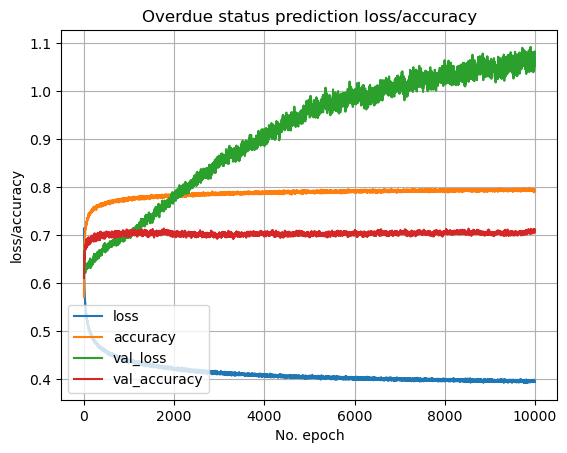

In [7]:
plt.plot(history_status.history['loss'], label='loss')
plt.plot(history_status.history['accuracy'], label='accuracy')
plt.plot(history_status.history['val_loss'], label='val_loss')
plt.plot(history_status.history['val_accuracy'], label='val_accuracy')
plt.title('Overdue status prediction loss/accuracy')
plt.ylabel('loss/accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower left")
plt.grid() # add grid
plt.show()

In [8]:
model_status.save('model_status_2') # best model is saved to ./model_status_2 file

INFO:tensorflow:Assets written to: model_status_2\assets
